##Generacja sygnałów **X** i zbioru zmiennych **y**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
import tensorflow as tf
import os
from tensorflow.keras import datasets, layers, models, losses, Model
from keras import backend
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR


In [ ]:
if os.path.isdir('SignalSeparation'):
    !rm -rf {'SignalSeparation'}
!git clone https://github.com/MieszkoP/SignalSeparation.git
from SignalSeparation import program as p

Cloning into 'SignalSeparation'...
remote: Enumerating objects: 44, done.
remote: Counting objects: 100% (44/44), done.
remote: Compressing objects: 100% (28/28), done.
remote: Total 44 (delta 11), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (44/44), done.


In [ ]:
size = 50000
X_data = np.zeros([size,1000])
Y_data = np.zeros([size,4])
for i in range(size):
  X_data[i,:], Y_data[i,0], Y_data[i,1], Y_data[i,2], Y_data[i,3] = p.GenerateSignal(np.random.uniform(0,100), 0.8, 15)

KeyboardInterrupt: ignored

In [ ]:
Y_new = p.Standardize(Y_data, 400, 500, 400, 600, 0.8, 15)

Zbiór **treningowy** i **walidacyjny**

In [ ]:
X = X_data

size = Y_new.shape[0]

Y_new_test = Y_new[:int(size*0.1),:]
X_t = X[:int(size*0.1),:]

Y_new = Y_new[int(size*0.1):,:]
X = X[int(size*0.1):,:]

## Utworzenie sieci neuronowej

Funkcja wagi

In [ ]:
CostHeightProp = p.CostFunction(p.RatioOfUniforms, 0.8, 15, 1, p.HeightProportionTensorflow(p.DeStandarizeHeight(Y_new[:,0], 0.8, 15),p.DeStandarizeHeight(Y_new[:,1], 0.8, 15)))
CostPlace2 = p.CostFunction(p.SumOfUniforms, 0.1, 0.9, 1, Y_new[:,3])

Zmodyfikowana funkcja kosztu dla $h_{ratio}$ 

In [ ]:
def mean_squared_error_new_height(y_true, y_pred, y_true1, y_true2):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)

  #Destandaryzacja do 0.8 - 15:

  y_true1 = p.DeStandarizeHeight(y_true1, 0.8, 15)
  y_true2 = p.DeStandarizeHeight(y_true2, 0.8, 15)
  
  return backend.mean(tf.math.squared_difference(y_pred, y_true)*CostHeightProp(p.HeightProportionTensorflow(y_true1, y_true2)), axis=-1)

In [ ]:
def height_dif(y_true, y_pred):
  return mean_squared_error_new_height(p.HeightProportionTensorflow(y_true[:,1], y_true[:,0]),p.HeightProportionTensorflow(y_pred[:,1],y_pred[:,0]), y_true[:,0], y_true[:,1])*0.00255

Zmodyfikowana funkcja kosztu dla $t_{m2}$

In [ ]:
def mean_squared_error_new_position2(y_true, y_pred):
  y_pred = tf.convert_to_tensor(y_pred)
  y_true = tf.cast(y_true, y_pred.dtype)

  #Destandaryzacja do 0.8 - 15:
  
  return backend.mean(tf.math.squared_difference(y_pred, y_true)*CostPlace2(y_true), axis=-1)

Funkcja kosztu dla $t_{\Delta}$

In [ ]:
def freq_dif(y_true, y_pred):

  true = p.PlacesChange(y_true[:,3], 0.1, 1.7)-y_true[:,2]
  pred = p.PlacesChange(y_pred[:,3], 0.1, 1.7)-y_pred[:,2]
  
  return tf.keras.losses.mean_squared_error(true,pred)*0.224

Funkcje kosztu dla $h_1$, $h_2$, $t_{m1}$ i dla $t_{m2}$

In [ ]:
def h1loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,0],y_pred[:,0])

def h2loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,1],y_pred[:,1])

def p1loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,2],y_pred[:,2])

def p2loss(y_true, y_pred):
  return mean_squared_error_new_position2(y_true[:,3],y_pred[:,3])

Finalna funkcja kosztu

In [ ]:
def custom_loss_function(y_true, y_pred):
  loss = height_dif(y_true, y_pred)+h1loss(y_true, y_pred)+h2loss(y_true, y_pred)+p1loss(y_true, y_pred)+p2loss(y_true, y_pred)+freq_dif(y_true, y_pred)
  #print(y_true[0,:])
  return loss

Model trenowanej sieci

In [ ]:
def TrainNetwork(seed, fork_point, optim, basic_lr, BatchNormalization):
  tf.random.set_seed(seed)
  
  model = p.CreateNetwork(BatchNormalization, fork_point) #Ustal czy w architekturze sieci będzie normalizacja Batch na początku czy nie

  opt = optim(learning_rate=basic_lr)
  model.compile(loss=custom_loss_function,
                optimizer=opt,
                metrics = [h1loss, h2loss, p1loss, p2loss, height_dif, freq_dif],
                run_eagerly=False)

  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')
  reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_lr=0.00001, min_delta=1e-4, mode='min')


  mymodel=model.fit(
      X,
      Y_new,
      batch_size=100,
      epochs=300,
      verbose=1,
      callbacks=[reduce_lr_loss, earlyStopping],
      validation_data = (X_t, Y_new_test)
  )

  print('Koniec uczenia')
  return mymodel

##Algorytm genetyczny

Definicja hiperparametrów i populacji algorytmu genetycznego

In [ ]:
x = p.Populaton(5, 5) #Zdefiniowanie populacji i hiperparametrów 
x.define_feature(1, "random state", [1, 2, 3]) 
x.define_feature(2, "network fork point", [1,3,5,7]) 
x.define_feature(3, "optimizer", [tf.keras.optimizers.Adam,tf.keras.optimizers.SGD, tf.keras.optimizers.Adagrad]) 
x.define_feature(4, "base learning rate", [0.001, 0.01, 0.05, 0.1]) 
x.define_feature(5, "BatchNormalization", [p.NoBatch, p.OnlyBeforeAct, p.OnlyAfterAct, p.AfterInput, p.AfterInputAndAfterAct, p.AfterInputAndBeforeAct]) 

Wczytywanie wcześniej wytrenowanych hiperparametrów

In [ ]:
x.Load('Stored.csv', 'Current.csv')

Trenowanie algorytmu

In [ ]:
beg=0
for itera in range(10):
  if beg==1:
    x.initialize()
    beg=0
  else:
    x.IndBeg()

  x.Check()
  for i in range(5):
    print(x.CheckIsMetricWrote())
    if not x.CheckIsMetricWrote(): #Sprawdzenie czy nie ma już policzonej metryki
      model = TrainNetwork(x.read(1), x.read(2), x.read(3), x.read(4), x.read(5))
      if not np.isnan(model.history['loss'][-1]):
        x.ReadMetric(-model.history['loss'][-1])
      else:
        x.ReadMetric(-100)
    x.nextInd()

  x.Store() #Zapisywanie w historii
  print('Wynik:')
  print(x.initialized)
  x.Sorting() #Sortowanie
  print('Wynik posortowany:')
  print(x.initialized)
  x.Selection() #Selekcja 
  print('Wynik wyselekcjonowany:')
  print(x.initialized)
  x.Crossing() #Krzyżowanie
  print('Wynik krzyżowaniu:')
  print(x.initialized)
  x.Mutation(0.2) #Mutacja ze wsp. mutacji 20%
  print('Wynik po mutacji:')
  print(x.initialized)
  x.Save()

False
Epoch 1/50
450/450 [==============================] - 22s 18ms/step - loss: 0.0517 - h1loss: 0.0173 - h2loss: 0.0182 - p1loss: 0.0042 - p2loss: 0.0029 - height_dif: 0.0059 - freq_dif: 0.0032 - val_loss: 2.3094 - val_h1loss: 0.3060 - val_h2loss: 0.2941 - val_p1loss: 0.2017 - val_p2loss: 0.2859 - val_height_dif: 0.7725 - val_freq_dif: 0.4493 - lr: 0.0500
Epoch 2/50
450/450 [==============================] - 7s 16ms/step - loss: 0.0274 - h1loss: 0.0103 - h2loss: 0.0104 - p1loss: 0.0012 - p2loss: 4.9708e-04 - height_dif: 0.0044 - freq_dif: 5.8874e-04 - val_loss: 2.3131 - val_h1loss: 0.3099 - val_h2loss: 0.2936 - val_p1loss: 0.2203 - val_p2loss: 0.2796 - val_height_dif: 0.7615 - val_freq_dif: 0.4482 - lr: 0.0500
Epoch 3/50
450/450 [==============================] - 7s 16ms/step - loss: 0.0246 - h1loss: 0.0091 - h2loss: 0.0092 - p1loss: 0.0012 - p2loss: 4.8054e-04 - height_dif: 0.0041 - freq_dif: 5.5178e-04 - val_loss: 1.7901 - val_h1loss: 0.2645 - val_h2loss: 0.3101 - val_p1loss: 0.04

### Wizualizacja hiperparametrow algorytmu

In [ ]:
import numpy as np
import pandas as pd
table = np.loadtxt('/content/DataStored (17).csv')
import matplotlib.pyplot as plt


In [ ]:
table = table[:,-1]

63

In [ ]:
tabtab = table.reshape(int(table.shape[0]/5),5)

Text(0.5, 0, 'Nr generacji')

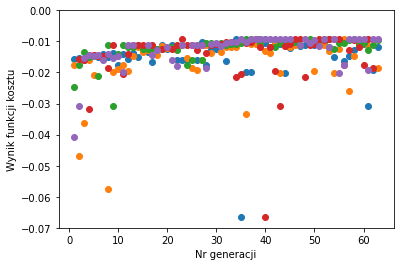

In [ ]:
plt.scatter(np.arange(1,tabtab.shape[0]+1),tabtab[:,0])

plt.scatter(np.arange(1,tabtab.shape[0]+1),tabtab[:,1])

plt.scatter(np.arange(1,tabtab.shape[0]+1),tabtab[:,2])

plt.scatter(np.arange(1,tabtab.shape[0]+1),tabtab[:,3])

plt.scatter(np.arange(1,tabtab.shape[0]+1),tabtab[:,4])

plt.ylim(-0.07, 0)
plt.ylabel('Wynik funkcji kosztu')
plt.xlabel('Nr generacji')

##Wyniki pracy sieci

In [ ]:
model = TrainNetwork(2, 5, tf.keras.optimizers.Adam, 0.01, p.OnlyAfterAct)

Epoch 1/300
450/450 [==============================] - 13s 20ms/step - loss: 0.0365 - h1loss: 0.0122 - h2loss: 0.0126 - p1loss: 0.0030 - p2loss: 0.0017 - height_dif: 0.0052 - freq_dif: 0.0019 - val_loss: 0.5764 - val_h1loss: 0.2299 - val_h2loss: 0.1340 - val_p1loss: 0.0173 - val_p2loss: 0.0479 - val_height_dif: 0.0660 - val_freq_dif: 0.0812 - lr: 0.0100
Epoch 2/300
450/450 [==============================] - 8s 18ms/step - loss: 0.0215 - h1loss: 0.0080 - h2loss: 0.0080 - p1loss: 8.2562e-04 - p2loss: 4.5521e-04 - height_dif: 0.0037 - freq_dif: 4.6723e-04 - val_loss: 1.3207 - val_h1loss: 0.1815 - val_h2loss: 0.2978 - val_p1loss: 0.0730 - val_p2loss: 0.0741 - val_height_dif: 0.5136 - val_freq_dif: 0.1806 - lr: 0.0100
Epoch 3/300
450/450 [==============================] - 8s 18ms/step - loss: 0.0196 - h1loss: 0.0074 - h2loss: 0.0073 - p1loss: 7.3557e-04 - p2loss: 3.1753e-04 - height_dif: 0.0035 - freq_dif: 3.9531e-04 - val_loss: 0.5812 - val_h1loss: 0.0722 - val_h2loss: 0.0242 - val_p1loss:

KeyboardInterrupt: ignored

In [ ]:
model.model.save_weights('wagi.h5')

In [ ]:
model.model.load_weights('wagi.h5')

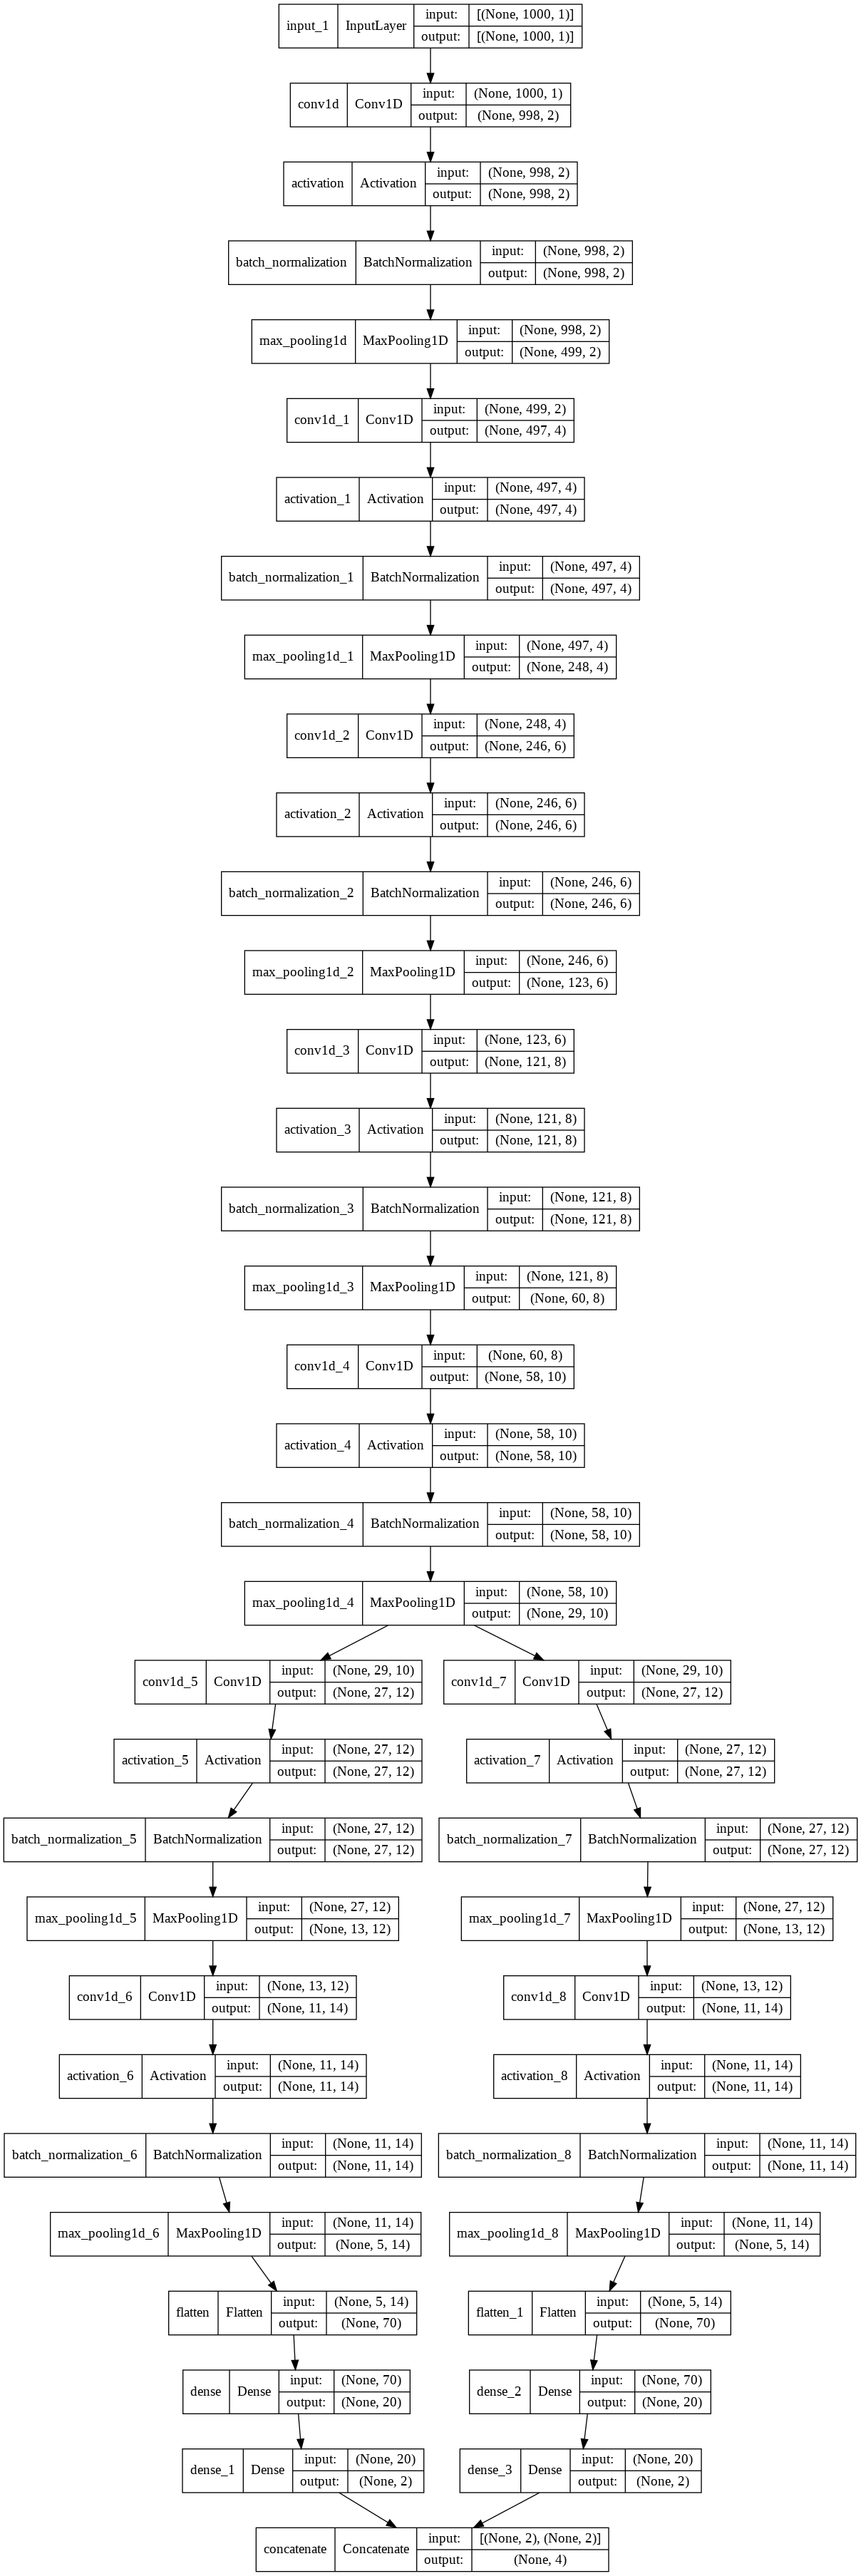

In [ ]:
tf.keras.utils.plot_model(model.model, "model.png", show_shapes=True)

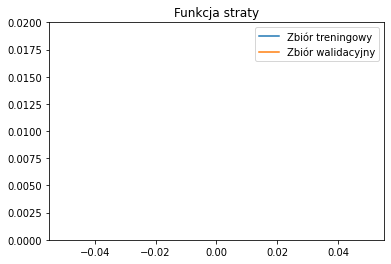

In [ ]:
plt.title('Funkcja straty')
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.legend(['Zbiór treningowy', 'Zbiór walidacyjny'])
plt.ylim(0, 0.02)
plt.show()

In [ ]:
y_pred_train = model.model.predict(X)
y_pred = model.model.predict(X_t)

In [ ]:
Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)

In [ ]:
from scipy.stats import pearsonr

In [ ]:
def ExcludeByDistance(l_top, l_bottom, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand):
  Y_destand_l = np.zeros((Y_destand.shape[0],4))
  Y_test_destand_l = np.zeros((Y_test_destand.shape[0],4))
  Y_pred_test_destand_l = np.zeros((Y_pred_test_destand.shape[0],4))
  Y_pred_destand_l = np.zeros((Y_pred_destand.shape[0],4))

  for i in range(4):
    k=0
    for j in range(Y_destand.shape[0]):
      #print(Y_destand[j,3]-Y_destand[j,2])
      if l_top>(Y_destand[j,3]-Y_destand[j,2])>l_bottom:
        Y_destand_l[k,i] = Y_destand[j,i]
        Y_pred_destand_l[k,i] = Y_pred_destand[j,i]
        k+=1
    Y_destand_l = Y_destand_l[:k,:]
    Y_pred_destand_l = Y_pred_destand_l[:k,:]

    k=0
    for j in range(Y_test_destand.shape[0]):
      if l_top>(Y_test_destand[j,3]-Y_test_destand[j,2])>l_bottom:
        Y_test_destand_l[k,i] = Y_test_destand[j,i]
        Y_pred_test_destand_l[k,i] = Y_pred_test_destand[j,i]
        k+=1
    Y_test_destand_l = Y_test_destand_l[:k,:]
    Y_pred_test_destand_l = Y_pred_test_destand_l[:k,:]
  return Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l

def PredRealChart(name, pred, true):
  fig, ax = plt.subplots()
  ax.scatter(true, pred, s=0.2)
  ax.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
  ax.set_xlabel('Prawdziwy/a '+name)
  ax.set_ylabel('Przewidywany/a '+name)
  plt.show()

def R2(pred, true):
  corr,_ = pearsonr(true,pred)
  return corr**2

def NMSE(pred, true):
  return np.mean((true-pred)**2)/np.var(true)

def ZYSK(NMSE0, NMSE1):
  return 100*(NMSE0-NMSE1)/NMSE0




In [ ]:
Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l = p.ExcludeByDistance(400, 10, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand)

In [ ]:
dane_pred0 = np.array(p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1]))

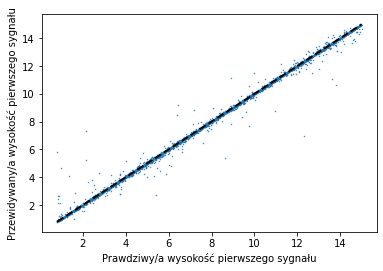

0.9955723640761682
0.004429973538231422


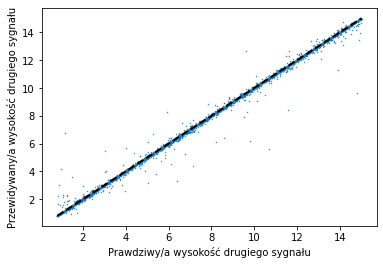

0.9956339438636012
0.004368218520234541


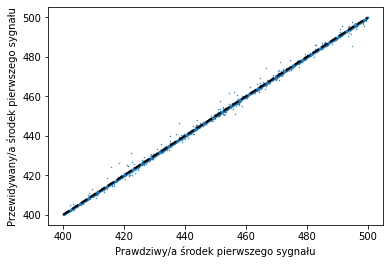

0.9994652126341493
0.0005356955525231175


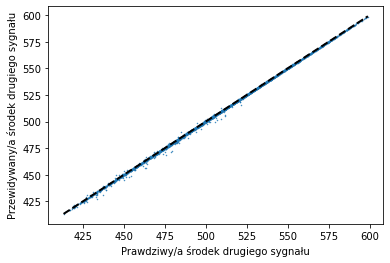

0.999708596234227
0.0002931257573973418


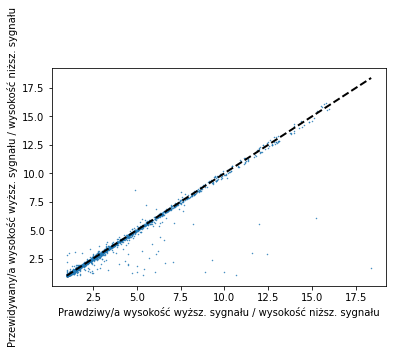

0.9447541761058192
0.055622782636355964


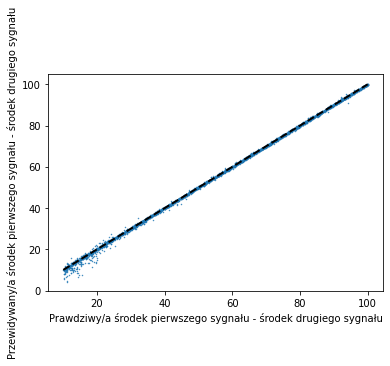

0.9992943403629513
0.0007314183704138444


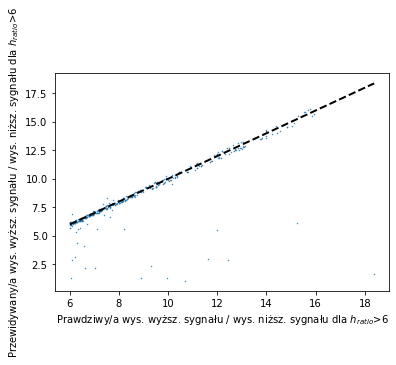

0.6655104212347996
0.4235931463109104


In [ ]:
arr= np.array([])
string = ['wysokość pierwszego sygnału', 'wysokość drugiego sygnału', 'środek pierwszego sygnału','środek drugiego sygnału']
for i in range(4):
  p.PredRealChart(string[i], Y_pred_destand_l[:,i], Y_destand_l[:,i])
  print(p.R2(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.R2(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  print(p.NMSE(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.NMSE(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.ZYSK(34, 34))
hr=6
string = ['wysokość wyższ. sygnału / wysokość niższ. sygnału', 'środek pierwszego sygnału - środek drugiego sygnału', 'wys. wyższ. sygnału / wys. niższ. sygnału dla $h_{ratio}$>'+str(hr)]

dane0 = np.array(p.HeightProportionTensorflow(Y_destand_l[:,1],Y_destand_l[:,0]))
dane1 = Y_destand_l[:,3]-Y_destand_l[:,2]

dane_pred0 = p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1])
dane_pred1 = Y_pred_destand_l[:,3]-Y_pred_destand_l[:,2]

p.PredRealChart(string[0], dane_pred0, dane0)
print(p.R2(dane_pred0, dane0))
arr = np.append(arr, p.R2(dane_pred0, dane0))
print(p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.ZYSK(34, 34))

p.PredRealChart(string[1], dane_pred1, dane1)
print(p.R2(dane_pred1, dane1))
arr = np.append(arr, p.R2(dane_pred1, dane1))
print(p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.ZYSK(34, 34))

newdane, newdane_pred = np.array([]), np.array([])
for i in range(len(dane0)):
  if dane0[i]>hr:
    newdane = np.append(newdane, dane0[i])
    newdane_pred = np.append(newdane_pred, dane_pred0[i])

p.PredRealChart(string[2], newdane_pred, newdane)

print(p.R2(newdane_pred, newdane))
arr = np.append(arr, p.R2(newdane_pred, newdane))
print(p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.ZYSK(34, 34))

In [ ]:
arr = arr.reshape(7,3)
arr2 = arr.sum(axis=0)
arr3 = np.vstack((arr, arr2))
np.savetxt("wyniki_zkosztem.txt", arr3, fmt='%.4f', delimiter=' & ')

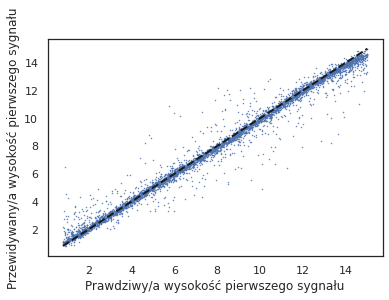

0.980766246740998
0.019872776391297406


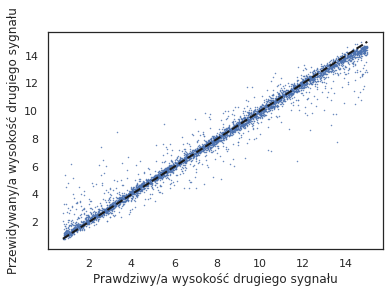

0.9816956814944567
0.019141363229865174


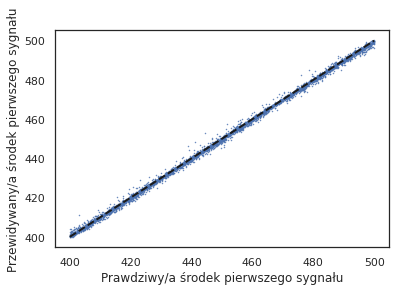

0.998882393054027
0.0011470158256654834


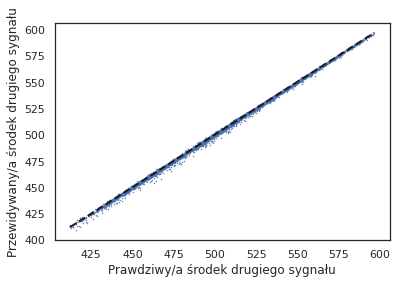

0.9991388838205395
0.0009233164130845495


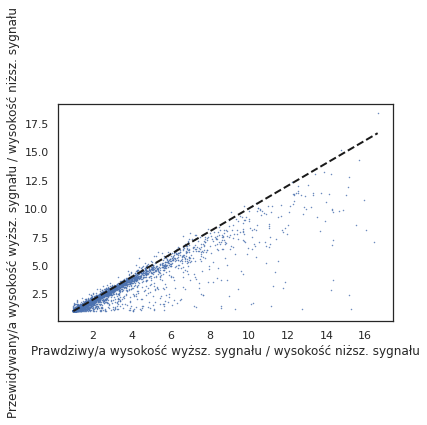

0.8509697183895678
0.18548394836272405


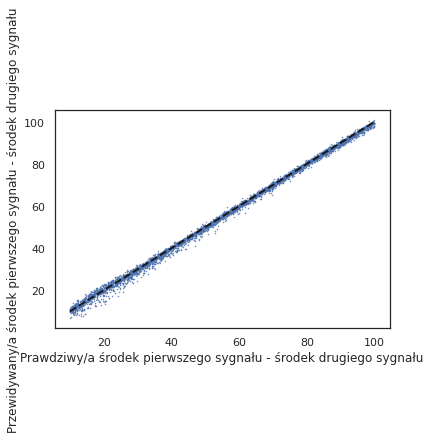

0.9979998680028451
0.0020336267492135868


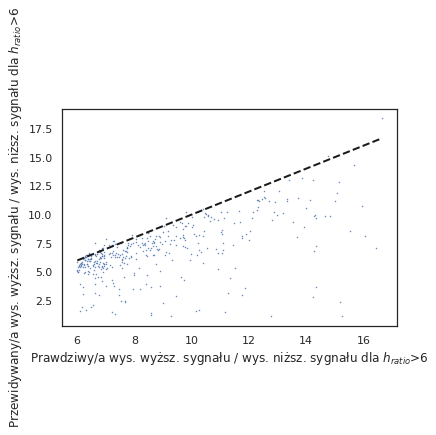

0.3406759678866904
1.442381159726824


In [ ]:
arr= np.array([])
string = ['wysokość pierwszego sygnału', 'wysokość drugiego sygnału', 'środek pierwszego sygnału','środek drugiego sygnału']
for i in range(4):
  p.PredRealChart(string[i], Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i])
  print(p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  print(p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.ZYSK(34, 34))
hr=6
string = ['wysokość wyższ. sygnału / wysokość niższ. sygnału', 'środek pierwszego sygnału - środek drugiego sygnału', 'wys. wyższ. sygnału / wys. niższ. sygnału dla $h_{ratio}$>'+str(hr)]

dane0 = np.array(p.HeightProportionTensorflow(Y_test_destand_l[:,1],Y_test_destand_l[:,0]))
dane1 = Y_test_destand_l[:,3]-Y_test_destand_l[:,2]

dane_pred0 = p.HeightProportionTensorflow(Y_pred_test_destand_l[:,0], Y_pred_test_destand_l[:,1])
dane_pred1 = Y_pred_test_destand_l[:,3]-Y_pred_test_destand_l[:,2]

p.PredRealChart(string[0], dane_pred0, dane0)
print(p.R2(dane_pred0, dane0))
arr = np.append(arr, p.R2(dane_pred0, dane0))
print(p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.ZYSK(34, 34))

p.PredRealChart(string[1], dane_pred1, dane1)
print(p.R2(dane_pred1, dane1))
arr = np.append(arr, p.R2(dane_pred1, dane1))
print(p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.ZYSK(34, 34))

newdane, newdane_pred = np.array([]), np.array([])
for i in range(len(dane0)):
  if dane0[i]>hr:
    newdane = np.append(newdane, dane0[i])
    newdane_pred = np.append(newdane_pred, dane_pred0[i])

p.PredRealChart(string[2], newdane_pred, newdane)

print(p.R2(newdane_pred, newdane))
arr = np.append(arr, p.R2(newdane_pred, newdane))
print(p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.ZYSK(34, 34))

## Optymalizacja parametrow $\gamma$ i $C$.  

In [ ]:
size = 8000
X_data = np.zeros([size,1000])
Y_data = np.zeros([size,4])
for i in range(size):
  X_data[i,:], Y_data[i,0], Y_data[i,1], Y_data[i,2], Y_data[i,3] = p.GenerateSignal(np.random.uniform(0,100), 0.8, 15)

Y_new = p.Standardize(Y_data, 400, 500, 400, 600, 0.8, 15)

X = X_data

size = Y_new.shape[0]

Y_new_test = Y_new[:int(size*0.5),:]
X_t = X[:int(size*0.5),:]

Y_new = Y_new[int(size*0.5):,:]
X = X[int(size*0.5):,:]

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

In [ ]:
model = p.CreateNetwork(p.OnlyAfterAct, 5)
model.load_weights('wagi.h5')

In [ ]:
hvector = Model(inputs=model.input,
                                 outputs=model.layers[-5].output)
pvector = Model(inputs=model.input,
                                 outputs=model.layers[-4].output)

Xp = pvector.predict(X)
Xh = hvector.predict(X)

Xp_t = pvector.predict(X_t)
Xh_t = hvector.predict(X_t)

In [ ]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR
# y - cztery kolumny

svr = SVR(epsilon=0.001,  kernel='rbf', C=10, gamma=1)
mor2 = MultiOutputRegressor(svr)
mor2.fit(Xh, Y_new[:, :2])
pred_train1 = mor2.predict(Xh)
pred_test1 = mor2.predict(Xh_t)

mor2.fit(Xp, Y_new[:, 2:])
pred_train2 = mor2.predict(Xp)
pred_test2 = mor2.predict(Xp_t)

In [ ]:
y_pred_train = np.hstack((pred_train1, pred_train2))
y_pred = np.hstack((pred_test1, pred_test2))
Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)

In [ ]:
arr0 = np.zeros((0,9))
arr2 = np.zeros((0,9))
for c in [1, 10, 100, 1000, 10000]:
  for gamma in [0.001, 0.01, 0.1, 1, 5]:
    arr0 = arr2
    print(c, gamma)

    

    svr = SVR(epsilon=0.001,  kernel='rbf', C=c, gamma=gamma)
    mor1 = MultiOutputRegressor(svr)
    mor1.fit(Xh, Y_new[:, :2])
    pred_train1 = mor1.predict(Xh)
    pred_test1 = mor1.predict(Xh_t)


    svr = SVR(epsilon=0.001,  kernel='rbf', C=c, gamma=gamma)
    mor2 = MultiOutputRegressor(svr)
    mor2.fit(Xp, Y_new[:, 2:])
    pred_train2 = mor2.predict(Xp)
    pred_test2 = mor2.predict(Xp_t)

    y_pred_train = np.hstack((pred_train1, pred_train2))
    y_pred = np.hstack((pred_test1, pred_test2))

    Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
    Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
    Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
    Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)

    Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l = p.ExcludeByDistance(400, 10, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand)
    dane_pred0 = np.array(p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1]))

    arr = np.array([c, gamma])

    
    for i in range(4):
      print(p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
      print(p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))

      arr = np.hstack([arr, p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i])])

    hr=6

    dane0 = np.array(p.HeightProportionTensorflow(Y_test_destand_l[:,1],Y_test_destand_l[:,0]))
    dane1 = Y_test_destand_l[:,3]-Y_test_destand_l[:,2]

    dane_pred0 = p.HeightProportionTensorflow(Y_pred_test_destand_l[:,0], Y_pred_test_destand_l[:,1])
    dane_pred1 = Y_pred_test_destand_l[:,3]-Y_pred_test_destand_l[:,2]

    print(p.R2(dane_pred0, dane0))
    print(p.NMSE(dane_pred0, dane0))
    arr = np.hstack([arr, p.NMSE(dane_pred0, dane0)])

    print(p.R2(dane_pred1, dane1))
    print(p.NMSE(dane_pred1, dane1))
    arr = np.hstack([arr, p.NMSE(dane_pred1, dane1)])

    #arr = np.array([])

    newdane, newdane_pred = np.array([]), np.array([])
    for i in range(len(dane0)):
      if dane0[i]>hr:
        newdane = np.append(newdane, dane0[i])
        newdane_pred = np.append(newdane_pred, dane_pred0[i])

    print(p.R2(newdane_pred, newdane))
    print(p.NMSE(newdane_pred, newdane))
    arr = np.hstack([arr, p.NMSE(newdane_pred, newdane)])

    #print(arr)
    arr2 = np.vstack([arr0, arr])

1 0.001
0.9797656820332795
0.020275515053310898
0.9788467255797676
0.021278476893691403
0.9953546205947659
0.004752827961864245
0.9975934415606602
0.002411101049208339
2.4784611041255068e-05
104.17529769368485
0.9909844750989611
0.009303491156890048
0.02686389314216837
1014.4025638068372
1 0.01
0.983256757922526
0.016781669396035346
0.9833857047385458
0.016656384980695785
0.9981444945260578
0.0018658980800040888
0.9991249521258725
0.0008764498618459894
0.8147998203521435
0.20265582037890523
0.9968026436512195
0.0033177266328823355
0.31481407951459517
1.4199534416329447
1 0.1
0.9848148985186381
0.015203144665119706
0.9847657844102867
0.015242152872900016
0.9986637721083298
0.0013440775211196767
0.9992641708177576
0.0007391480090087326
0.8754219623608488
0.1264594003939681
0.9977055068015951
0.0024229897373453523
0.4660377513865274
0.8686866784946388
1 1
0.9777721531197955
0.022229153836989146
0.9788082532081835
0.02119346330357775
0.9989145543103262
0.0010908800739298273
0.9993734706534

KeyboardInterrupt: ignored

In [ ]:
arr2

array([[1.00000000e+00, 1.00000000e-03, 2.02755151e-02, 2.12784769e-02,
        4.75282796e-03, 2.41110105e-03, 1.04175298e+02, 9.30349116e-03,
        1.01440256e+03],
       [1.00000000e+00, 1.00000000e-02, 1.67816694e-02, 1.66563850e-02,
        1.86589808e-03, 8.76449862e-04, 2.02655820e-01, 3.31772663e-03,
        1.41995344e+00],
       [1.00000000e+00, 1.00000000e-01, 1.52031447e-02, 1.52421529e-02,
        1.34407752e-03, 7.39148009e-04, 1.26459400e-01, 2.42298974e-03,
        8.68686678e-01],
       [1.00000000e+00, 1.00000000e+00, 2.22291538e-02, 2.11934633e-02,
        1.09088007e-03, 6.28561236e-04, 2.62664109e-01, 1.66182500e-03,
        1.77956290e+00],
       [1.00000000e+00, 5.00000000e+00, 7.16793817e-02, 6.21029651e-02,
        4.74141601e-03, 4.35146339e-03, 5.80524379e-01, 4.58162578e-03,
        5.05856196e+00],
       [1.00000000e+01, 1.00000000e-03, 1.78655253e-02, 1.76772615e-02,
        2.57035747e-03, 1.03330219e-03, 9.78621312e-01, 4.31577152e-03,
        8.7

In [ ]:
df = pd.DataFrame(arr2, columns=['c', '$\gamma$', 'h1', 'h2', 'p1', 'p2', 'h_ratio', 'pdelta','h_ratio6'])

In [ ]:
df

,c,$\gamma$,h1,h2,p1,p2,h_ratio,pdelta,h_ratio6
0,1.0,0.001,0.020276,0.021278,0.004753,0.002411,104.175298,0.009303,1014.402564
1,1.0,0.010,0.016782,0.016656,0.001866,0.000876,0.202656,0.003318,1.419953
2,1.0,0.100,0.015203,0.015242,0.001344,0.000739,0.126459,0.002423,0.868687
3,1.0,1.000,0.022229,0.021193,0.001091,0.000629,0.262664,0.001662,1.779563
4,1.0,5.000,0.071679,0.062103,0.004741,0.004351,0.580524,0.004582,5.058562
5,10.0,0.001,0.017866,0.017677,0.002570,0.001033,0.978621,0.004316,8.716696
6,10.0,0.010,0.015801,0.015909,0.001456,0.000794,0.173289,0.002733,1.195905
7,10.0,0.100,0.015920,0.016231,0.001185,0.000647,55.647967,0.001947,541.954311
8,10.0,1.000,0.038043,0.037756,0.001097,0.000620,12.591179,0.001668,3.057871
9,10.0,5.000,0.076244,0.067788,0.005216,0.004752,0.637143,0.005472,4.974769


In [ ]:
h1 = df.pivot('c', '$\gamma$', 'h1')
h2 = df.pivot('c', '$\gamma$', 'h2')

p1 = df.pivot('c', '$\gamma$', 'p1')
p2 = df.pivot('c', '$\gamma$', 'p2')

h_ratio = df.pivot('c', '$\gamma$', 'h_ratio')
pdelta = df.pivot('c', '$\gamma$', 'pdelta')
h_ratio6 = df.pivot('c', '$\gamma$', 'h_ratio6')

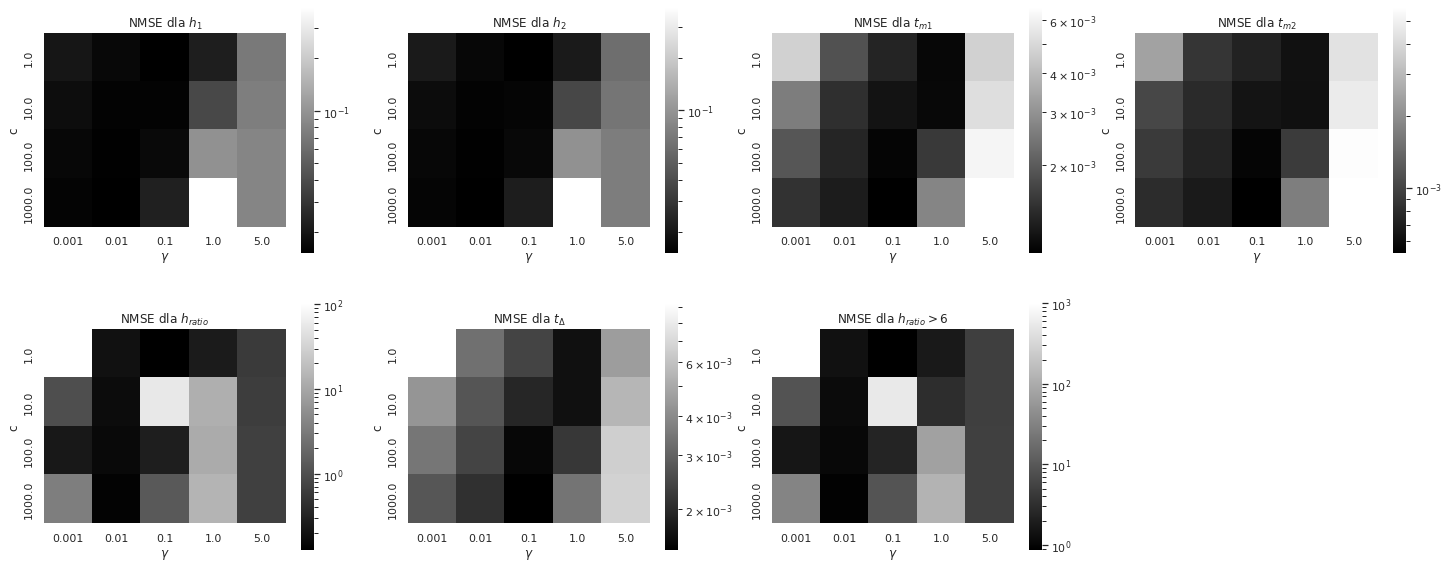

In [ ]:
import numpy as np
import seaborn as sns; sns.set_theme(style='white')
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from matplotlib.ticker import MaxNLocator
plt.figure(figsize=(25, 10))
plt.subplot(2,4,1)
plt.title('NMSE dla $h_1$')
sns.heatmap(h1, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,2)
plt.title('NMSE dla $h_2$')
sns.heatmap(h2, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,3)
plt.title('NMSE dla $t_{m1}$')
sns.heatmap(p1, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,4)
plt.title('NMSE dla $t_{m2}$')
sns.heatmap(p2, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,5)
plt.title('NMSE dla $h_{ratio}$')
sns.heatmap(h_ratio, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,6)
plt.title('NMSE dla $t_{\Delta}$')
sns.heatmap(pdelta, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,7)
plt.title('NMSE dla $h_{ratio}>6$')
sns.heatmap(h_ratio6, square=True, norm=LogNorm(), cmap='gray')

plt.subplot(2,4,7)
plt.title('Suma NMSE dla wszystkich zmiennych$')
sns.heatmap(h_ratio6, square=True, norm=LogNorm(), cmap='gray')


##Finalna Ocena

In [ ]:
size = 50000
X_data = np.zeros([size,1000])
Y_data = np.zeros([size,4])
for i in range(size):
  X_data[i,:], Y_data[i,0], Y_data[i,1], Y_data[i,2], Y_data[i,3] = p.GenerateSignal(np.random.uniform(0,100), 0.8, 15)

Y_new = p.Standardize(Y_data, 400, 500, 400, 600, 0.8, 15)

X = X_data

size = Y_new.shape[0]

Y_new_test = Y_new[:int(size*0.1),:]
X_t = X[:int(size*0.1),:]

Y_new = Y_new[int(size*0.1):,:]
X = X[int(size*0.1):,:]

In [ ]:
CostHeightProp = p.CostFunction(p.RatioOfUniforms, 0.8, 15, 1, p.HeightProportionTensorflow(p.DeStandarizeHeight(Y_new[:,0], 0.8, 15),p.DeStandarizeHeight(Y_new[:,1], 0.8, 15)))
CostPlace2 = p.CostFunction(p.SumOfUniforms, 0.1, 0.9, 1, Y_new[:,3])
model = TrainNetwork(2, 5, tf.keras.optimizers.Adam, 0.01, p.OnlyAfterAct)

#model = p.CreateNetwork(p.OnlyAfterAct, 5)
#model.load_weights('wagi.h5')

hvector = Model(inputs=model.model.input,
                                 outputs=model.model.layers[-5].output)
pvector = Model(inputs=model.model.input,
                                 outputs=model.model.layers[-4].output)

Xp = pvector.predict(X)
Xh = hvector.predict(X)

Xp_t = pvector.predict(X_t)
Xh_t = hvector.predict(X_t)

from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

svr = SVR(epsilon=0.001,  kernel='rbf', C=1, gamma=0.1)
mor2a = MultiOutputRegressor(svr)
mor2a.fit(Xh, Y_new[:, :2])
pred_train1 = mor2a.predict(Xh)
pred_test1 = mor2a.predict(Xh_t)

mor2b = MultiOutputRegressor(svr)
mor2b.fit(Xp, Y_new[:, 2:])
pred_train2 = mor2b.predict(Xp)
pred_test2 = mor2b.predict(Xp_t)

Epoch 1/300
450/450 [==============================] - 32s 31ms/step - loss: 0.0342 - h1loss: 0.0114 - h2loss: 0.0115 - p1loss: 0.0027 - p2loss: 0.0018 - height_dif: 0.0048 - freq_dif: 0.0020 - val_loss: 0.4638 - val_h1loss: 0.2990 - val_h2loss: 0.0678 - val_p1loss: 0.0251 - val_p2loss: 0.0090 - val_height_dif: 0.0568 - val_freq_dif: 0.0061 - lr: 0.0100
Epoch 2/300
450/450 [==============================] - 10s 22ms/step - loss: 0.0204 - h1loss: 0.0077 - h2loss: 0.0077 - p1loss: 7.4566e-04 - p2loss: 3.1393e-04 - height_dif: 0.0036 - freq_dif: 3.4887e-04 - val_loss: 0.4631 - val_h1loss: 0.0230 - val_h2loss: 0.0359 - val_p1loss: 0.0962 - val_p2loss: 0.1226 - val_height_dif: 0.0086 - val_freq_dif: 0.1767 - lr: 0.0100
Epoch 3/300
450/450 [==============================] - 8s 18ms/step - loss: 0.0189 - h1loss: 0.0070 - h2loss: 0.0072 - p1loss: 6.4826e-04 - p2loss: 3.1060e-04 - height_dif: 0.0033 - freq_dif: 3.2448e-04 - val_loss: 0.0446 - val_h1loss: 0.0203 - val_h2loss: 0.0139 - val_p1loss

In [ ]:
svr = SVR(epsilon=0.001,  kernel='rbf', C=1, gamma=0.1)
mor2a = MultiOutputRegressor(svr)
mor2a.fit(Xh, Y_new[:, :2])
pred_train1 = mor2a.predict(Xh)
pred_test1 = mor2a.predict(Xh_t)

mor2b = MultiOutputRegressor(svr)
mor2b.fit(Xp, Y_new[:, 2:])
pred_train2 = mor2b.predict(Xp)
pred_test2 = mor2b.predict(Xp_t)

In [ ]:
import pickle
pickle.dump(mor2a, open('SVRh', 'wb'))
pickle.dump(mor2b, open('SVRp', 'wb'))

In [ ]:
import pickle
pickle.dump(model.model, open('final_network', 'wb'))

INFO:tensorflow:Assets written to: ram://056263c5-77dc-421c-a480-2173658680e1/assets


In [ ]:
y_pred_train = np.hstack((pred_train1, pred_train2))
y_pred = np.hstack((pred_test1, pred_test2))
Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)
Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l = p.ExcludeByDistance(400, 10, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand)
dane_pred0 = np.array(p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1]))

###Zbiór treningowy

0.9869786638996468
0.013023484993162651
0.9870789716010993
0.012922798669450699
0.9989022963927641
0.001102574535371162
0.9992199269807676
0.0007920827080867815
0.896509390724993
0.1048082701614415
0.9980013550438218
0.002128155885943509
0.49014291352049044
0.7802539454491657


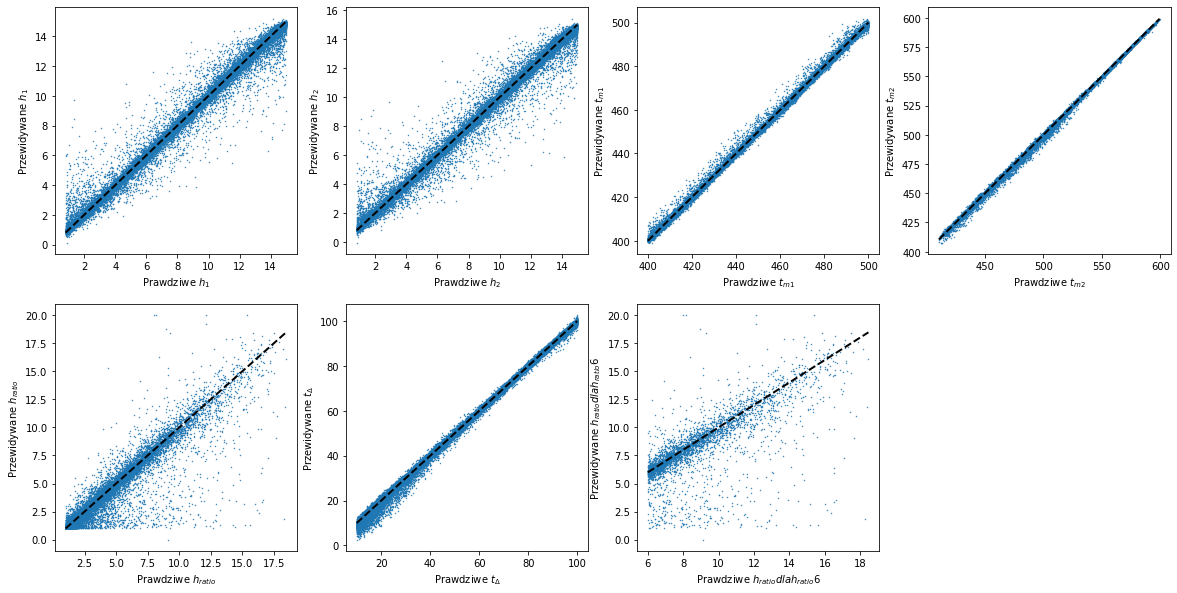

In [ ]:
arr= np.array([])
o=1
plt.figure(figsize=[20,10])
string = ['$h_{1}$', '$h_{2}$', '$t_{m1}$','$t_{m2}$']
for i in range(4):
  plt.subplot(2,4,o)
  o+=1
  PredRealChart(string[i], Y_pred_destand_l[:,i], Y_destand_l[:,i])
  print(p.R2(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.R2(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  print(p.NMSE(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.NMSE(Y_pred_destand_l[:,i], Y_destand_l[:,i]))
  arr = np.append(arr, p.ZYSK(34, 34))
hr=6

string = ['$h_{ratio}$', '$t_{\Delta}$', '$h_{ratio} dla h_{ratio}$'+str(hr)]

dane0 = np.array(p.HeightProportionTensorflow(Y_destand_l[:,1],Y_destand_l[:,0]))
dane1 = Y_destand_l[:,3]-Y_destand_l[:,2]

dane_pred0 = p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1])
dane_pred1 = Y_pred_destand_l[:,3]-Y_pred_destand_l[:,2]

plt.subplot(2,4,5)
PredRealChart(string[0], dane_pred0, dane0)
print(p.R2(dane_pred0, dane0))
arr = np.append(arr, p.R2(dane_pred0, dane0))
print(p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.ZYSK(34, 34))

plt.subplot(2,4,6)
PredRealChart(string[1], dane_pred1, dane1)
print(p.R2(dane_pred1, dane1))
arr = np.append(arr, p.R2(dane_pred1, dane1))
print(p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.ZYSK(34, 34))

newdane, newdane_pred = np.array([]), np.array([])
for i in range(len(dane0)):
  if dane0[i]>hr:
    newdane = np.append(newdane, dane0[i])
    newdane_pred = np.append(newdane_pred, dane_pred0[i])

plt.subplot(2,4,7)
PredRealChart(string[2], newdane_pred, newdane)

print(p.R2(newdane_pred, newdane))
arr = np.append(arr, p.R2(newdane_pred, newdane))
print(p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.ZYSK(34, 34))

###Zbiór testowy

0.9877647907274899
0.012242140904072975
0.9882393033120732
0.011766216171314719
0.9989972167089443
0.0010063726582127976
0.9992472117878349
0.0007620123252041122
0.9041433261880022
0.09708394193322775
0.998092919436135
0.00200999759101954
0.551792000315714
0.6676934231279542


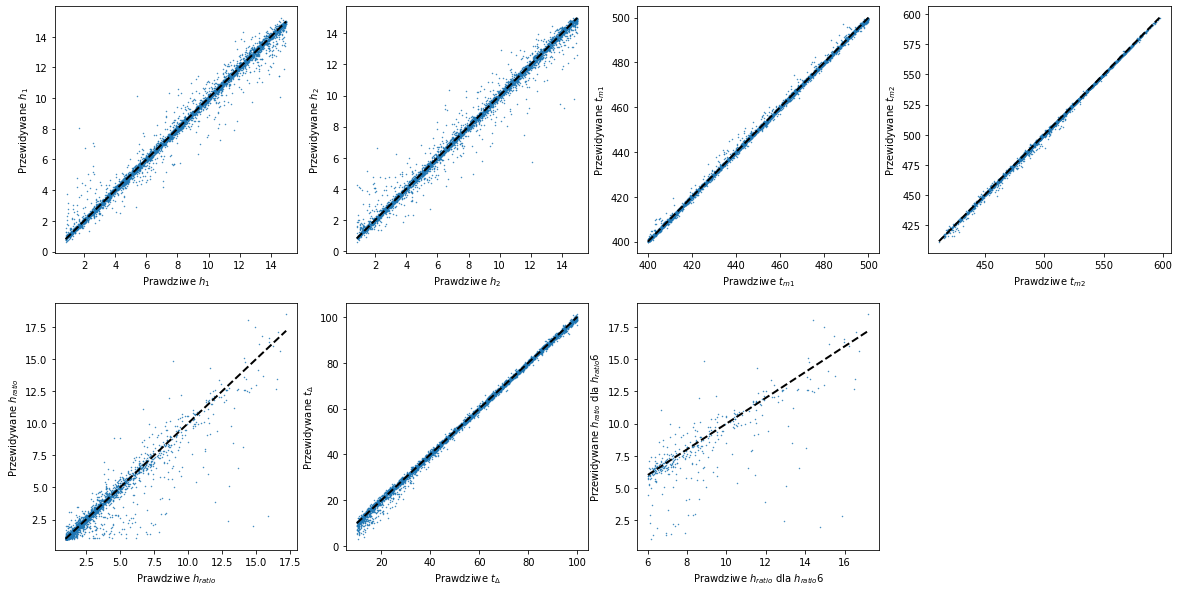

In [ ]:
arr= np.array([])
o=1
plt.figure(figsize=[20,10])
string = ['$h_{1}$', '$h_{2}$', '$t_{m1}$','$t_{m2}$']
for i in range(4):
  plt.subplot(2,4,o)
  o+=1
  PredRealChart(string[i], Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i])
  print(p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  print(p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.ZYSK(34, 34))
hr=6

string = ['$h_{ratio}$', '$t_{\Delta}$', '$h_{ratio}$ dla $h_{ratio}$'+str(hr)]

dane0 = np.array(p.HeightProportionTensorflow(Y_test_destand_l[:,1],Y_test_destand_l[:,0]))
dane1 = Y_test_destand_l[:,3]-Y_test_destand_l[:,2]

dane_pred0 = p.HeightProportionTensorflow(Y_pred_test_destand_l[:,0], Y_pred_test_destand_l[:,1])
dane_pred1 = Y_pred_test_destand_l[:,3]-Y_pred_test_destand_l[:,2]

plt.subplot(2,4,5)
PredRealChart(string[0], dane_pred0, dane0)
print(p.R2(dane_pred0, dane0))
arr = np.append(arr, p.R2(dane_pred0, dane0))
print(p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.ZYSK(34, 34))

plt.subplot(2,4,6)
PredRealChart(string[1], dane_pred1, dane1)
print(p.R2(dane_pred1, dane1))
arr = np.append(arr, p.R2(dane_pred1, dane1))
print(p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.ZYSK(34, 34))

newdane, newdane_pred = np.array([]), np.array([])
for i in range(len(dane0)):
  if dane0[i]>hr:
    newdane = np.append(newdane, dane0[i])
    newdane_pred = np.append(newdane_pred, dane_pred0[i])

plt.subplot(2,4,7)
PredRealChart(string[2], newdane_pred, newdane)

print(p.R2(newdane_pred, newdane))
arr = np.append(arr, p.R2(newdane_pred, newdane))
print(p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.ZYSK(34, 34))

In [ ]:
arr = arr.reshape(7,3)
arr20 = arr.sum(axis=0)
arr9 = np.vstack((arr, arr20))
np.savetxt("wyniki5.txt", arr9, fmt='%.4f', delimiter=' & ')

###Koszt dla zbioru testowego i treningowego

In [ ]:
def PredRealChart(name, pred, true):
  plt.scatter(true, pred, s=0.2)
  plt.plot([true.min(), true.max()], [true.min(), true.max()], 'k--', lw=2)
  plt.xlabel('Prawdziwe '+name)
  plt.ylabel('Przewidywane '+name)

(0.0, 0.05)

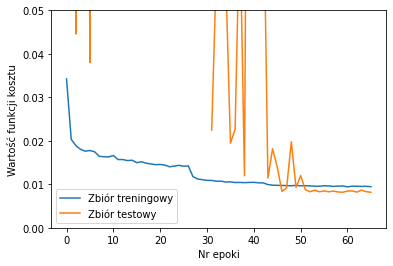

In [ ]:
plt.plot(model.history['loss'])
plt.plot(model.history['val_loss'])
plt.ylabel('Wartość funkcji kosztu')
plt.xlabel('Nr epoki')
plt.legend(['Zbiór treningowy', 'Zbiór testowy'])
plt.ylim(0,0.05)

###Symulacja identyfikacji próbki

In [ ]:
n=20

def GenerateSignal(height_ratio, df, bottom_border, top_border): #Wygeneruj sygnał o ustalonym stosunku wysokości pików (pik2/pik1) i o ustalonej odległości df. Rozmiar pików losowy (ale w taki spoób aby stosunek wysokości sie zgadzał), miejsce tez losowe (od 400 do 500)
  
  if height_ratio<0:
    height1 = np.random.uniform(0.8,15/(abs(height_ratio)+1))
    height2 = height1*(abs(height_ratio)+1)
  else:
    height1 = np.random.uniform(0.8*(abs(height_ratio)+1),15)
    height2 = height1/(abs(height_ratio)+1)


  x = np.arange(0,1000,1)
  place1 = np.random.uniform(400,500)
  place2 = place1+df
  y_f1 = scipy.stats.norm(place1, 100/2.355)
  y1 = y_f1.pdf(x)*100/2.355*(2*3.14)**(1/2)*height1
  y_f2 = scipy.stats.norm(place2, 100/2.355)
  y2 = y_f2.pdf(x)*100/2.355*(2*3.14)**(1/2)*height2
  y = y1+y2
  y = np.random.normal(loc=0, scale=0.005, size=1000)+y
  return y, height1, height2, place1, place2

In [ ]:
def predicting(model_n, mor2a, mor2b, signal):
  inp = np.zeros((1,1000))
  inp[0,:] = signal
  
  

  Xp = pvector.predict(inp)
  Xh = hvector.predict(inp)

  out1 = mor2a.predict(Xh)
  out2 = mor2b.predict(Xp)
  
  out = np.hstack((out1, out2))
  out = p.DeStandarize(out, 400, 500, 400, 600, 0.8, 15)
  return out

In [ ]:
data = GenerateSignal(0,90, 0.8, 15)
predicted = predicting(model, mor2a, mor2b, data[0])[0,:]

[]


In [ ]:
model.model.

In [ ]:
data[1:]

(10.812846625123372, 10.812846625123372, 473.13197139730414, 563.1319713973041)

In [ ]:
predicted

array([ 10.85443151,  10.90525117, 473.18463527, 563.77528834])

Stosunek wysokości = 1


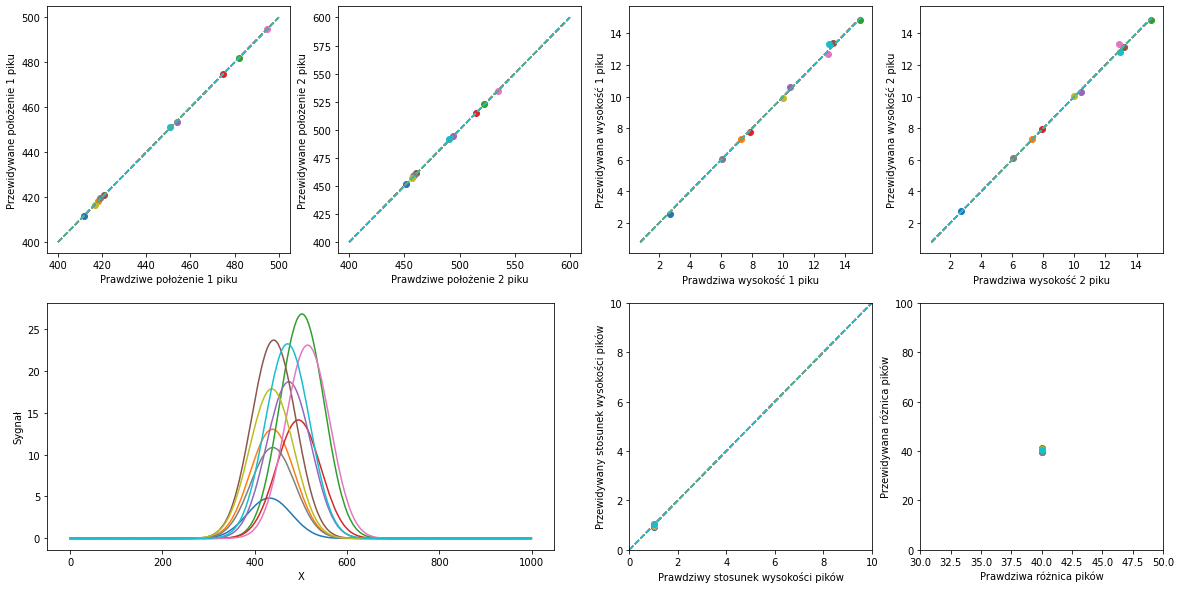

Stosunek wysokości = 2


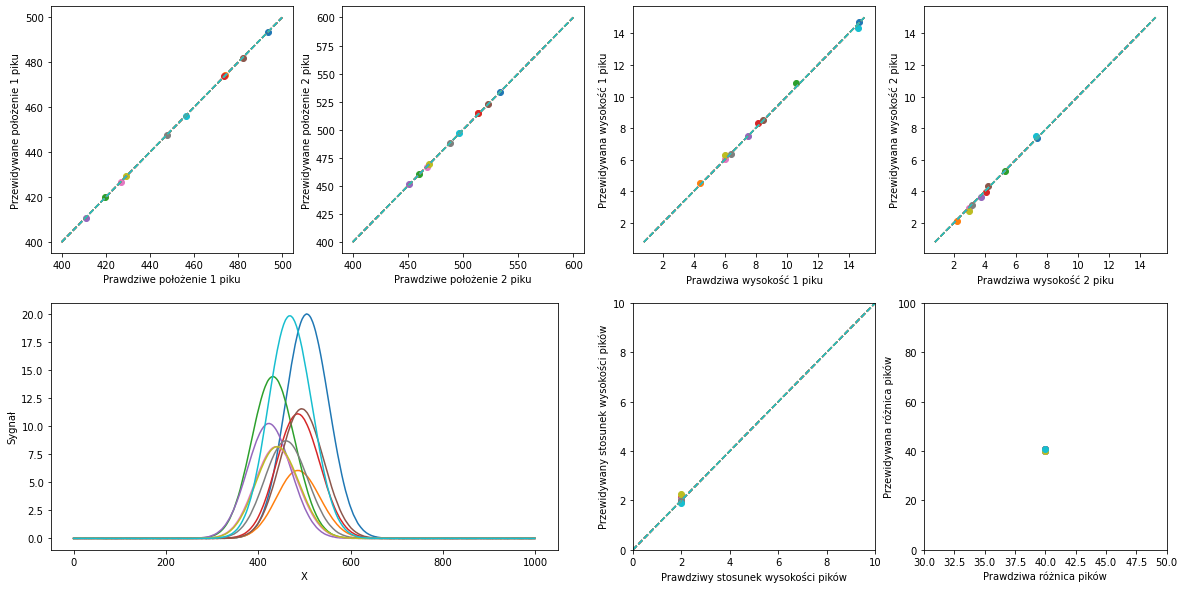

Stosunek wysokości = 3


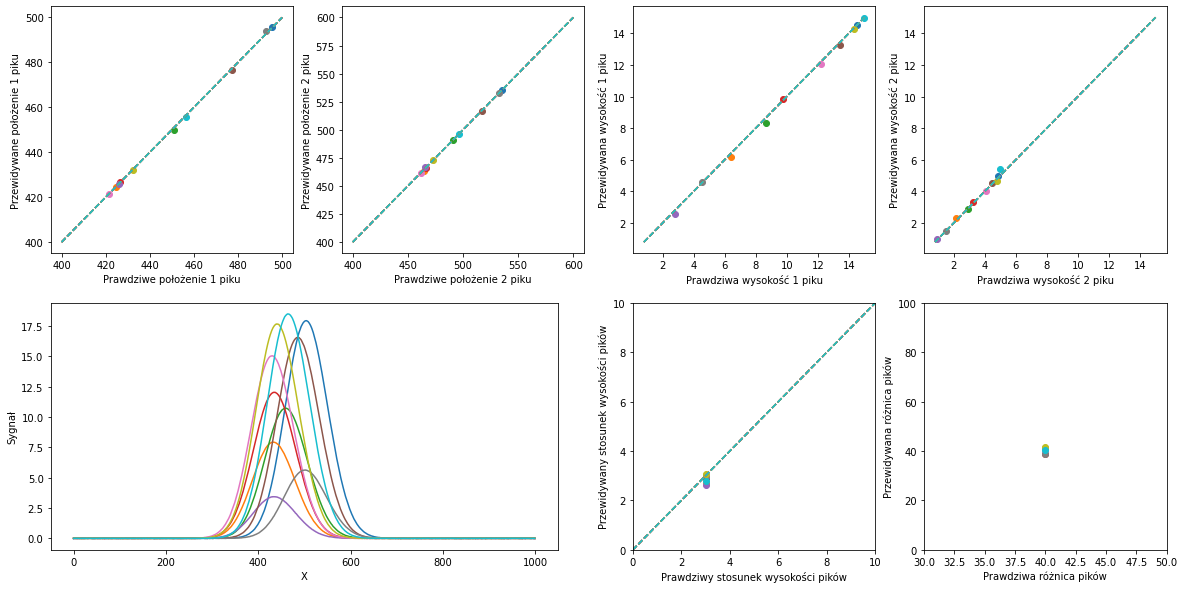

Stosunek wysokości = 4


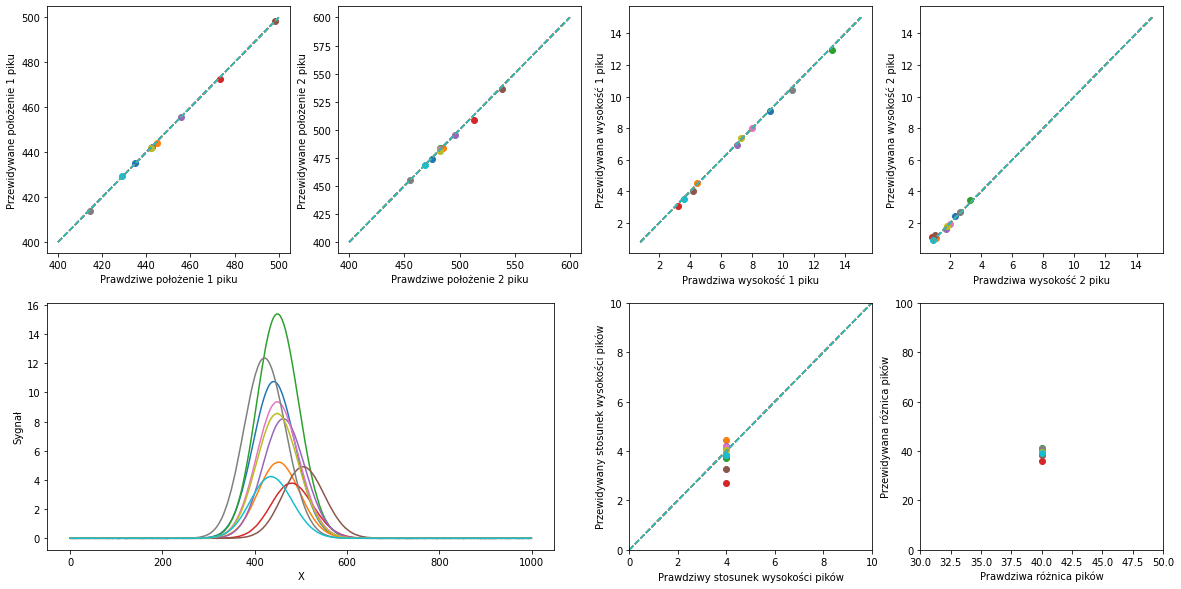

Stosunek wysokości = 5


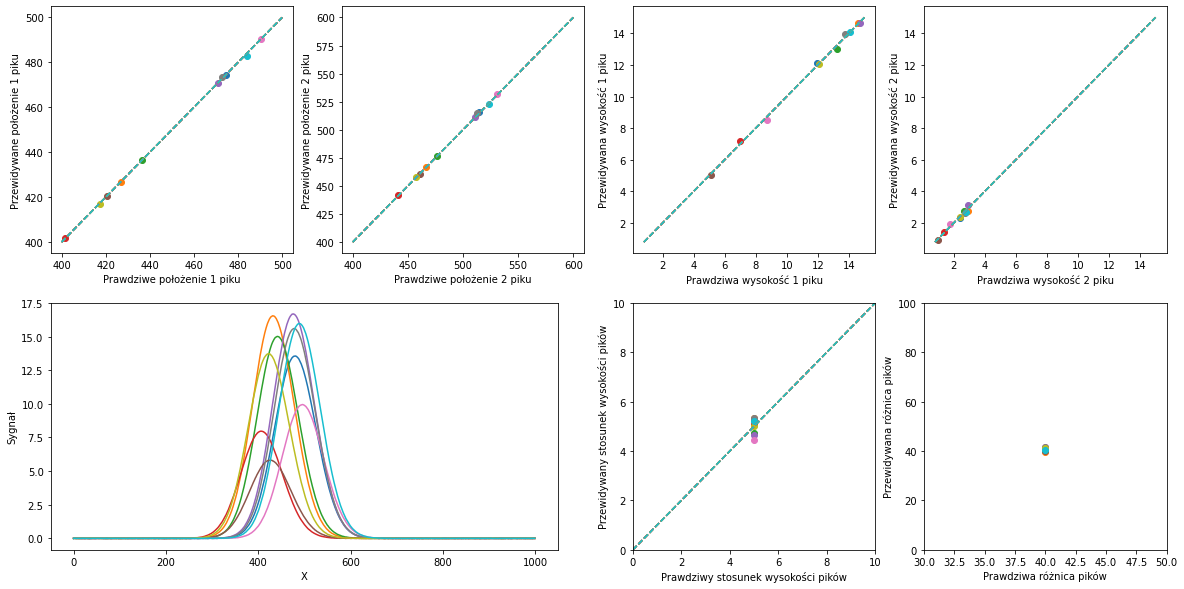

Stosunek wysokości = 6


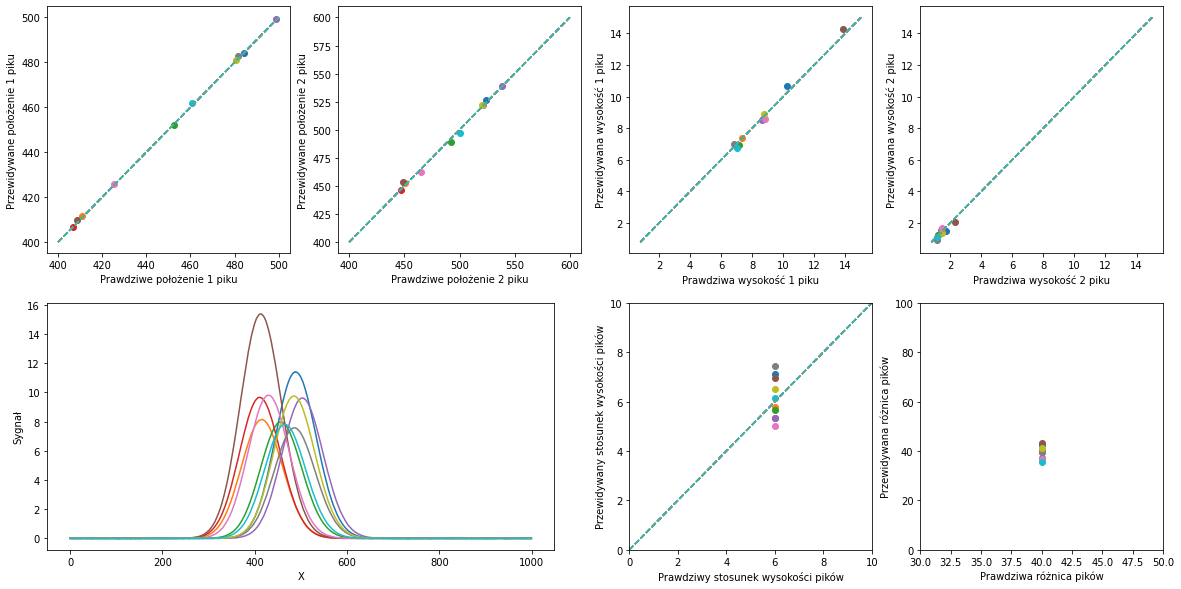

Stosunek wysokości = 7


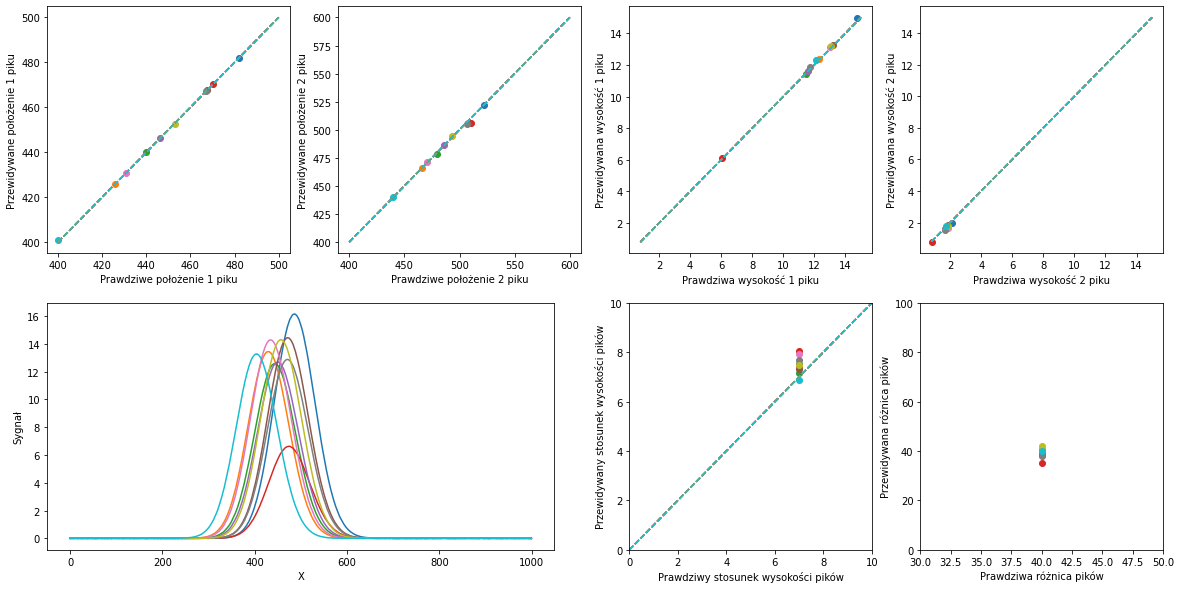

Stosunek wysokości = 8


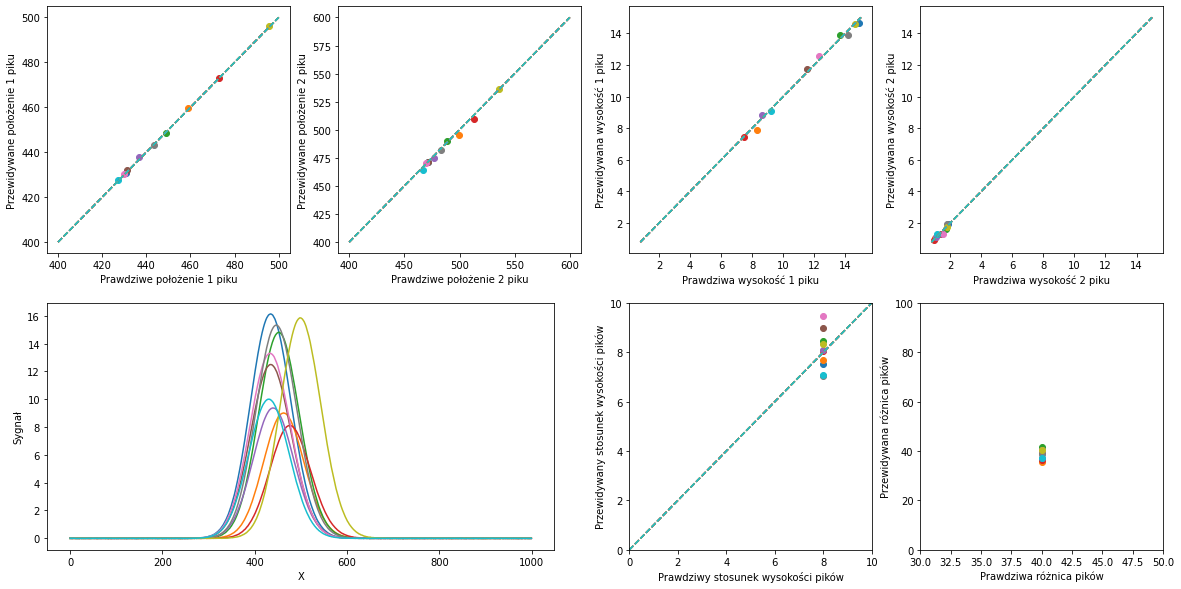

Stosunek wysokości = 9


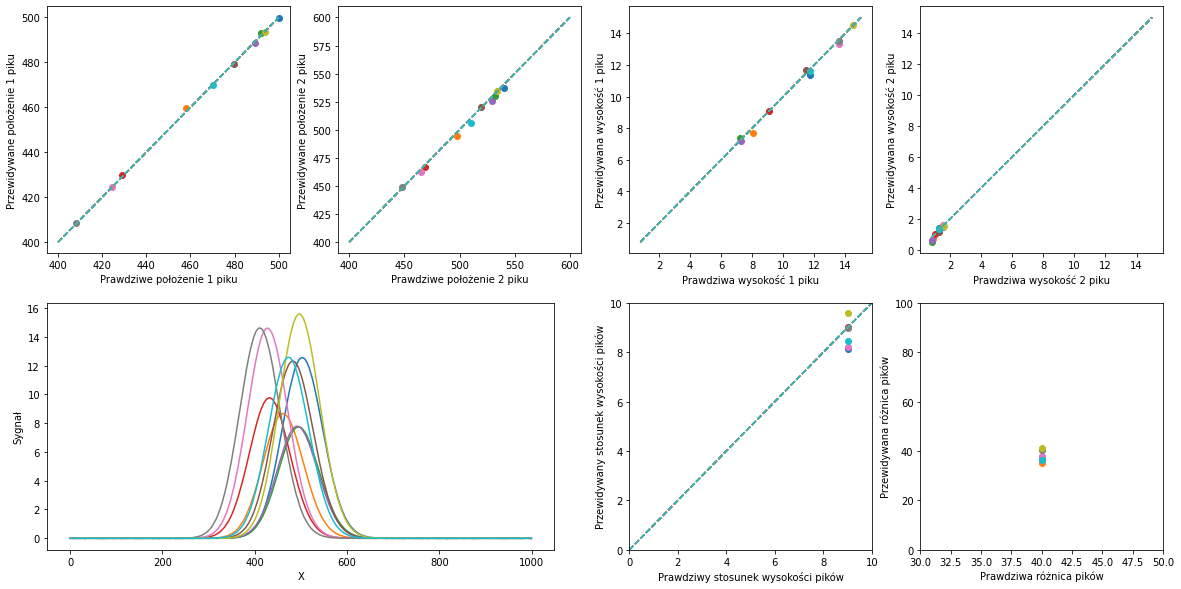

Stosunek wysokości = 10


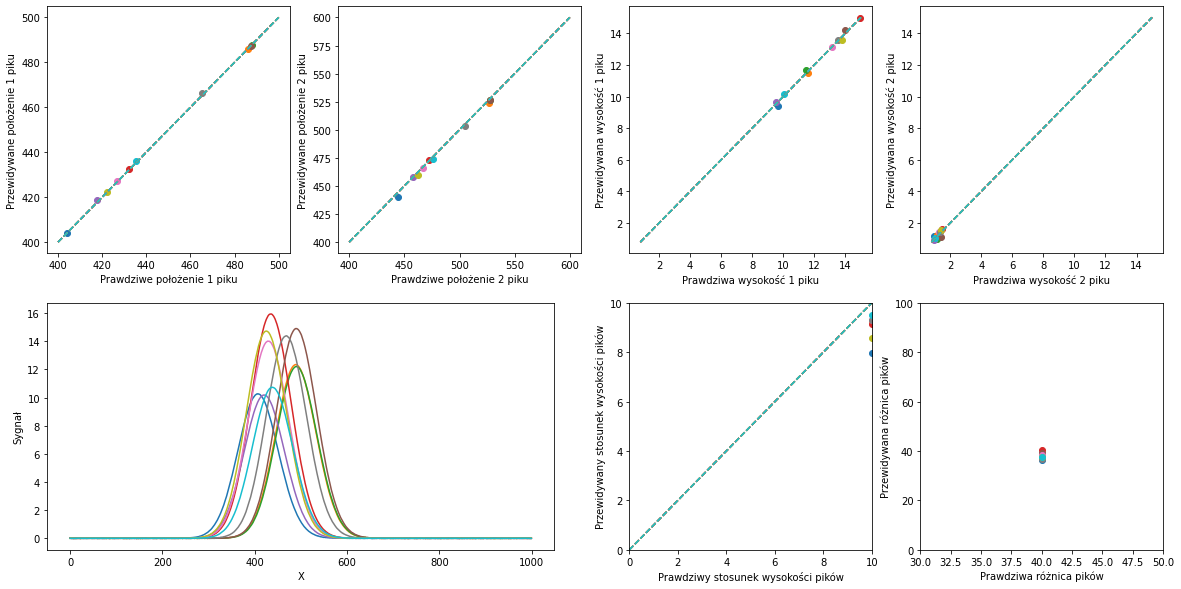

In [ ]:
import warnings

warnings.filterwarnings("ignore",category=UserWarning)

for j in range(0,10):
  print("Stosunek wysokości = "+str(j+1))
  plt.figure(figsize=[20,10])
  for i in range(0,10):
    #print(np.log10(j))
    data = GenerateSignal(j,40, 0.8, 15)
    predicted = predicting(model, mor2a, mor2b, data[0])[0,:]

    plt.subplot(2,4,1)
    plt.scatter(data[3], predicted[2])
    plt.xlabel('Prawdziwe położenie 1 piku')
    plt.ylabel('Przewidywane położenie 1 piku')
    plt.plot([400, 500], [400, 500], '--')

    plt.subplot(2,4,2)
    plt.scatter(data[4], predicted[3])
    plt.xlabel('Prawdziwe położenie 2 piku')
    plt.ylabel('Przewidywane położenie 2 piku')
    plt.plot([400, 600], [400, 600], '--')

    plt.subplot(2,4,3)
    plt.scatter(data[1], predicted[0])
    plt.xlabel('Prawdziwa wysokość 1 piku')
    plt.ylabel('Przewidywana wysokość 1 piku')
    plt.plot([0.8, 15], [0.8, 15], '--')

    plt.subplot(2,4,4)
    plt.scatter(data[2], predicted[1])
    plt.xlabel('Prawdziwa wysokość 2 piku')
    plt.ylabel('Przewidywana wysokość 2 piku')
    plt.plot([0.8, 15], [0.8, 15], '--')

    plt.subplot(2,4,7)
    plt.scatter(data[1]/data[2], predicted[0]/predicted[1])
    plt.xlabel('Prawdziwy stosunek wysokości pików')
    plt.ylabel('Przewidywany stosunek wysokości pików')
    plt.ylim(0,10)
    plt.xlim(0,10)
    plt.plot([0, 10], [0, 10], '--')

    plt.subplot(2,4,8)
    plt.scatter(data[4]-data[3], predicted[3]-predicted[2])
    plt.xlabel('Prawdziwa różnica pików')
    plt.ylabel('Przewidywana różnica pików')
    plt.xlim(30,50)
    plt.ylim(0,100)
    #plt.plot([0.8, 15], [0.8, 15], '--')

    #plt.
    plt.subplot(2,2,3)
    plt.plot(data[0])
    plt.xlabel('X')
    plt.ylabel('Sygnał')

  plt.show()

In [ ]:
simulations_height = np.ones((20, 8, 10))
simulations_dif = np.ones((20, 8, 10))

In [ ]:
import warnings

warnings.filterwarnings("ignore",category=UserWarning)

for j in range(0,20):
  print("Stosunek wysokości = "+str(j+1))
  plt.figure(figsize=[20,10])
  for i in range(0,10):
    #print(np.log10(j))
    data = GenerateSignal(j,40, 0.8, 15)
    
    predicted = predicting(model, mor2a, mor2b, data[0])[0,:]
    predicted[3]-predicted[2]
    predicted[0]/predicted[1]

In [ ]:
for x in range(10,85,10):
  print(x)

10
20
30
40
50
60
70
80


In [ ]:
for height in range(0,10):
  for t_delta in range(0,8):
    for n in range(0,20):
      data = GenerateSignal(height,10*(t_delta+1), 0.8, 15)
      predicted = predicting(model, mor2a, mor2b, data[0])[0,:]
      simulations_height[n, t_delta, height] = predicted[0]/predicted[1]
      simulations_dif[n, t_delta, height] = predicted[3]-predicted[2]

In [ ]:
arr = np.mean(simulations_dif, axis=0)

In [ ]:
arr[0]

array([1.00824484, 1.80474901, 1.89680294, 1.7390354 , 1.67241054,
       2.64107401, 2.12293075, 1.42456557, 1.51387773, 1.43248509])

In [ ]:
std = np.std(simulations_dif, axis=0)

In [ ]:
std = np.round(std, 2)
arr = np.round(arr, 2)

In [ ]:
arr

array([[ 9.64,  8.74,  8.56,  7.38,  7.07,  6.66,  6.81,  6.42,  5.77,
         5.67],
       [20.67, 19.87, 18.8 , 18.06, 16.88, 15.99, 15.21, 14.17, 13.85,
        12.97],
       [30.24, 30.29, 30.02, 29.54, 29.4 , 27.68, 26.75, 25.87, 25.69,
        25.43],
       [39.8 , 40.45, 40.53, 40.15, 39.75, 39.64, 38.82, 38.21, 37.61,
        37.43],
       [50.48, 50.25, 49.9 , 49.94, 49.94, 49.77, 50.06, 48.97, 48.84,
        48.83],
       [60.03, 59.92, 60.  , 59.75, 60.06, 60.34, 59.22, 59.37, 59.38,
        58.5 ],
       [70.21, 70.29, 69.97, 70.27, 70.13, 70.12, 69.63, 69.94, 69.97,
        69.12],
       [80.08, 80.27, 80.09, 80.47, 80.65, 80.37, 80.63, 80.56, 80.19,
        80.49]])

In [ ]:
MakeTable(arr, std)

'$t_{\\delta}$=10& $9.64$   & $8.74$   & $8.56$   & $7.38$   & $7.07$   & $6.66$   & $6.81$   & $6.42$   & $5.77$   & $5.67$   \\& ($ 1.08 $)& ($ 0.91 $)& ($ 1.28 $)& ($ 1.23 $)& ($ 0.97 $)& ($ 1.36 $)& ($ 1.09 $)& ($ 1.58 $)& ($ 1.08 $)& ($ 1.14 $) \\hline$t_{\\delta}$=20& $20.67$   & $19.87$   & $18.8$   & $18.06$   & $16.88$   & $15.99$   & $15.21$   & $14.17$   & $13.85$   & $12.97$   \\& ($ 0.8 $)& ($ 1.03 $)& ($ 1.65 $)& ($ 1.5 $)& ($ 2.11 $)& ($ 1.37 $)& ($ 1.24 $)& ($ 1.0 $)& ($ 1.04 $)& ($ 1.21 $) \\hline$t_{\\delta}$=30& $30.24$   & $30.29$   & $30.02$   & $29.54$   & $29.4$   & $27.68$   & $26.75$   & $25.87$   & $25.69$   & $25.43$   \\& ($ 0.96 $)& ($ 0.68 $)& ($ 1.25 $)& ($ 1.51 $)& ($ 1.43 $)& ($ 1.66 $)& ($ 1.65 $)& ($ 1.65 $)& ($ 1.35 $)& ($ 1.42 $) \\hline$t_{\\delta}$=40& $39.8$   & $40.45$   & $40.53$   & $40.15$   & $39.75$   & $39.64$   & $38.82$   & $38.21$   & $37.61$   & $37.43$   \\& ($ 0.59 $)& ($ 0.84 $)& ($ 1.06 $)& ($ 1.4 $)& ($ 1.46 $)& ($ 1.51 $)& ($ 1.6

In [ ]:
def MakeTable(ar_all, arstd):
  st = str()
  for k in range(0,8):
    st+='$t_{\delta}$='+str((k+1)*10)
    ar = ar_all[k,:]
    len(ar)
    for i in range(len(ar)):
      st = st + '& $'+str(ar[i])+'$   '
    st+='\\'
    for i in range(len(ar)):
      st+='& ($ '+ str(arstd[k,i])+' $)'
    st+=' \hline'
  return st

##Trenowanie bez modyfikacji funkcji kosztu (dla porównania)

Funkcje kosztu dla $h_1$, $h_2$, $t_{m1}$ i dla $t_{m2}$

In [ ]:
def h1loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,0],y_pred[:,0])

def h2loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,1],y_pred[:,1])

def p1loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,2],y_pred[:,2])

def p2loss(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(y_true[:,3],y_pred[:,3])

def freq_dif(y_true, y_pred):

  true = p.PlacesChange(y_true[:,3], 0.1, 1.7)-y_true[:,2]
  pred = p.PlacesChange(y_pred[:,3], 0.1, 1.7)-y_pred[:,2]
  return tf.keras.losses.mean_squared_error(true,pred)*0.224

def height_dif(y_true, y_pred):
  return tf.keras.losses.mean_squared_error(p.HeightProportionTensorflow(y_true[:,1], y_true[:,0]),p.HeightProportionTensorflow(y_pred[:,1],y_pred[:,0]))*0.00255

In [ ]:
def custom_loss_function(y_true, y_pred):
  loss = height_dif(y_true, y_pred)+h1loss(y_true, y_pred)+h2loss(y_true, y_pred)+p1loss(y_true, y_pred)+p2loss(y_true, y_pred)+freq_dif(y_true, y_pred)
  #print(y_true[0,:])
  return loss

def TrainNetwork(seed, fork_point, optim, basic_lr, BatchNormalization):
  tf.random.set_seed(seed)
  
  model = p.CreateNetwork(BatchNormalization, fork_point) #Ustal czy w architekturze sieci będzie normalizacja Batch na początku czy nie

  opt = optim(learning_rate=basic_lr)
  model.compile(loss=custom_loss_function,
                optimizer=opt,
                metrics = [h1loss, h2loss, p1loss, p2loss, height_dif, freq_dif],
                run_eagerly=False)

  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')
  reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_lr=0.00001, min_delta=1e-4, mode='min')


  mymodel=model.fit(
      X,
      Y_new,
      batch_size=100,
      epochs=100,
      verbose=1,
      callbacks=[reduce_lr_loss, earlyStopping],
      validation_data = (X_t, Y_new_test)
  )

  print('Koniec uczenia')
  return mymodel

In [ ]:
model = TrainNetwork(2, 5, tf.keras.optimizers.Adam, 0.01, p.OnlyAfterAct)

Epoch 1/100
450/450 [==============================] - 49s 98ms/step - loss: 0.0365 - h1loss: 0.0129 - h2loss: 0.0128 - p1loss: 0.0031 - p2loss: 0.0019 - height_dif: 0.0036 - freq_dif: 0.0022 - val_loss: 0.2193 - val_h1loss: 0.0190 - val_h2loss: 0.0259 - val_p1loss: 0.0390 - val_p2loss: 0.0494 - val_height_dif: 0.0050 - val_freq_dif: 0.0809 - lr: 0.0100
Epoch 2/100
450/450 [==============================] - 45s 101ms/step - loss: 0.0211 - h1loss: 0.0084 - h2loss: 0.0085 - p1loss: 9.0591e-04 - p2loss: 3.6529e-04 - height_dif: 0.0025 - freq_dif: 4.0400e-04 - val_loss: 0.2359 - val_h1loss: 0.0751 - val_h2loss: 0.0364 - val_p1loss: 0.0174 - val_p2loss: 0.0394 - val_height_dif: 0.0131 - val_freq_dif: 0.0545 - lr: 0.0100
Epoch 3/100
450/450 [==============================] - 47s 104ms/step - loss: 0.0191 - h1loss: 0.0076 - h2loss: 0.0076 - p1loss: 7.9228e-04 - p2loss: 3.1173e-04 - height_dif: 0.0023 - freq_dif: 3.8671e-04 - val_loss: 0.8618 - val_h1loss: 0.0416 - val_h2loss: 0.0564 - val_p1l

In [ ]:
y_pred_train = model.model.predict(X)
y_pred = model.model.predict(X_t)

In [ ]:
Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)
Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l = p.ExcludeByDistance(400, 10, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand)
dane_pred0 = np.array(p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1]))

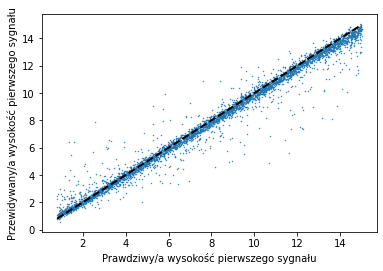

0.9790166188508858
0.022473837439576056


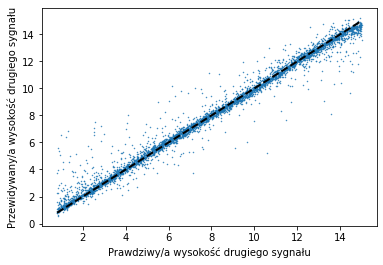

0.9802466429964551
0.02037733459285314


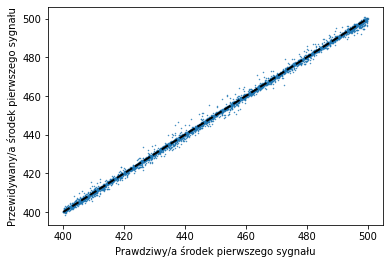

0.9985395447007117
0.0014624011825668387


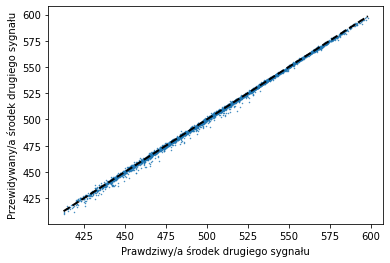

0.9989079147266485
0.0011256881249599505


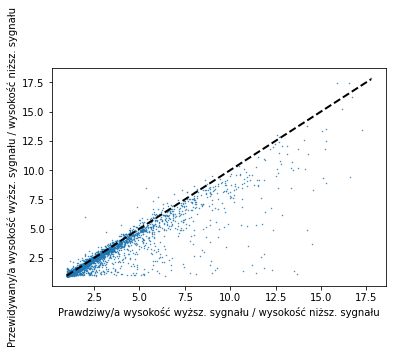

0.8430067040153358
0.1834457235687403


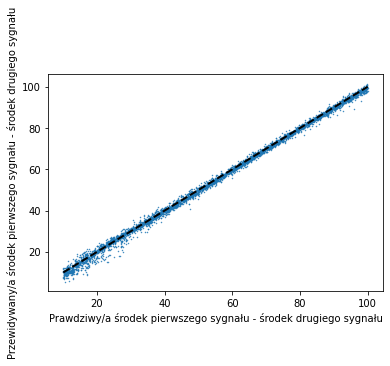

0.997627736829095
0.0024781913147370774


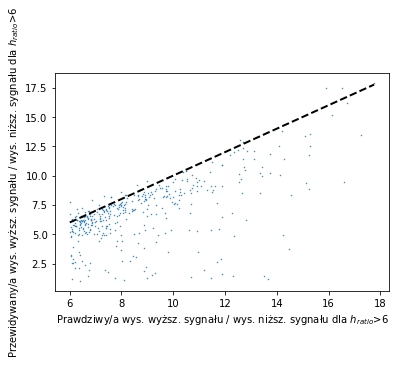

0.3713776959747779
1.4537876387861783


In [ ]:
arr= np.array([])
string = ['wysokość pierwszego sygnału', 'wysokość drugiego sygnału', 'środek pierwszego sygnału','środek drugiego sygnału']
for i in range(4):
  p.PredRealChart(string[i], Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i])
  print(p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.R2(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  print(p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i]))
  arr = np.append(arr, p.ZYSK(34, 34))
hr=6
string = ['wysokość wyższ. sygnału / wysokość niższ. sygnału', 'środek pierwszego sygnału - środek drugiego sygnału', 'wys. wyższ. sygnału / wys. niższ. sygnału dla $h_{ratio}$>'+str(hr)]

dane0 = np.array(p.HeightProportionTensorflow(Y_test_destand_l[:,1],Y_test_destand_l[:,0]))
dane1 = Y_test_destand_l[:,3]-Y_test_destand_l[:,2]

dane_pred0 = p.HeightProportionTensorflow(Y_pred_test_destand_l[:,0], Y_pred_test_destand_l[:,1])
dane_pred1 = Y_pred_test_destand_l[:,3]-Y_pred_test_destand_l[:,2]

p.PredRealChart(string[0], dane_pred0, dane0)
print(p.R2(dane_pred0, dane0))
arr = np.append(arr, p.R2(dane_pred0, dane0))
print(p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.NMSE(dane_pred0, dane0))
arr = np.append(arr, p.ZYSK(34, 34))

p.PredRealChart(string[1], dane_pred1, dane1)
print(p.R2(dane_pred1, dane1))
arr = np.append(arr, p.R2(dane_pred1, dane1))
print(p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.NMSE(dane_pred1, dane1))
arr = np.append(arr, p.ZYSK(34, 34))

newdane, newdane_pred = np.array([]), np.array([])
for i in range(len(dane0)):
  if dane0[i]>hr:
    newdane = np.append(newdane, dane0[i])
    newdane_pred = np.append(newdane_pred, dane_pred0[i])

p.PredRealChart(string[2], newdane_pred, newdane)

print(p.R2(newdane_pred, newdane))
arr = np.append(arr, p.R2(newdane_pred, newdane))
print(p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.NMSE(newdane_pred, newdane))
arr = np.append(arr, p.ZYSK(34, 34))

In [ ]:
arr = arr.reshape(7,3)
arr20 = arr.sum(axis=0)
arr9 = np.vstack((arr, arr20))
np.savetxt("wyniki5.txt", arr9, fmt='%.4f', delimiter=' & ')

##Walidacja krzyżowa 10-krotna

In [ ]:
np.random.seed(0)

In [ ]:
def TrainNetwork(seed, fork_point, optim, basic_lr, BatchNormalization, X, Y_new):
  tf.random.set_seed(seed)
  
  model = p.CreateNetwork(BatchNormalization, fork_point) #Ustal czy w architekturze sieci będzie normalizacja Batch na początku czy nie

  opt = optim(learning_rate=basic_lr)
  model.compile(loss=custom_loss_function,
                optimizer=opt,
                metrics = [h1loss, h2loss, p1loss, p2loss, height_dif, freq_dif],
                run_eagerly=False)

  earlyStopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, verbose=1, mode='min')
  reduce_lr_loss = tf.keras.callbacks.ReduceLROnPlateau(monitor='loss', factor=0.1, patience=4, verbose=1, min_lr=0.00001, min_delta=1e-4, mode='min')


  mymodel=model.fit(
      X,
      Y_new,
      batch_size=100,
      epochs=300,
      verbose=1,
      callbacks=[reduce_lr_loss, earlyStopping],
      validation_data = (X_t, Y_new_test)
  )

  print('Koniec uczenia')
  return mymodel

In [ ]:
np.random.seed(0)
size = 50000
X_data = np.zeros([size,1000])
Y_data = np.zeros([size,4])
for i in range(size):
  X_data[i,:], Y_data[i,0], Y_data[i,1], Y_data[i,2], Y_data[i,3] = p.GenerateSignal(np.random.uniform(0,100), 0.8, 15)

Y_new_all = p.Standardize(Y_data, 400, 500, 400, 600, 0.8, 15)

size = Y_new_all.shape[0]

In [ ]:
np.savetxt('XData.txt',X_data)

In [ ]:
np.savetxt('Y_data_as.txt',Y_new_all)

In [ ]:
arr0 = np.zeros((0,7))
arr2 = np.zeros((0,7))
for it in np.arange(1,11):
  
  arr0 = arr2
  print(it)
  Y_new_test = Y_new_all[int(size*0.1*(it-1)):int(size*0.1*it),:]
  X_t = X_data[int(size*0.1*(it-1)):int(size*0.1*it),:]

  Y_new = np.vstack((Y_new_all[:int(size*0.1*(it-1)),:], Y_new_all[int(size*0.1*it):,:]))
  X = np.vstack((X_data[:int(size*0.1*(it-1)),:], X_data[int(size*0.1*it):,:]))

  CostHeightProp = p.CostFunction(p.RatioOfUniforms, 0.8, 15, 1, p.HeightProportionTensorflow(p.DeStandarizeHeight(Y_new[:,0], 0.8, 15),p.DeStandarizeHeight(Y_new[:,1], 0.8, 15)))
  CostPlace2 = p.CostFunction(p.SumOfUniforms, 0.1, 0.9, 1, Y_new[:,3])

  model = TrainNetwork(2, 5, tf.keras.optimizers.Adam, 0.01, p.OnlyAfterAct, X, Y_new)

  hvector = Model(inputs=model.model.input,
                                 outputs=model.model.layers[-5].output)
  
  pvector = Model(inputs=model.model.input,
                                 outputs=model.model.layers[-4].output)

  svr = SVR(epsilon=0.001,  kernel='rbf', C=1, gamma=0.1)

  Xp = pvector.predict(X)
  Xh = hvector.predict(X)

  Xp_t = pvector.predict(X_t)
  Xh_t = hvector.predict(X_t)

  mor2 = MultiOutputRegressor(svr)

  mor2.fit(Xh, Y_new[:, :2])
  pred_train1 = mor2.predict(Xh)
  pred_test1 = mor2.predict(Xh_t)

  mor2.fit(Xp, Y_new[:, 2:])
  pred_train2 = mor2.predict(Xp)
  pred_test2 = mor2.predict(Xp_t)

  y_pred_train = np.hstack((pred_train1, pred_train2))
  y_pred = np.hstack((pred_test1, pred_test2))

  Y_destand = p.DeStandarize(Y_new, 400, 500, 400, 600, 0.8, 15)
  Y_test_destand = p.DeStandarize(Y_new_test, 400, 500, 400, 600, 0.8, 15)
  Y_pred_test_destand = p.DeStandarize(y_pred, 400, 500, 400, 600, 0.8, 15)
  Y_pred_destand = p.DeStandarize(y_pred_train, 400, 500, 400, 600, 0.8, 15)

  Y_destand_l, Y_test_destand_l, Y_pred_test_destand_l, Y_pred_destand_l = p.ExcludeByDistance(400, 10, Y_destand, Y_test_destand, Y_pred_test_destand, Y_pred_destand)
  dane_pred0 = np.array(p.HeightProportionTensorflow(Y_pred_destand_l[:,0], Y_pred_destand_l[:,1]))

  arr = np.array([])


  for i in range(4):
    arr = np.hstack([arr, p.NMSE(Y_pred_test_destand_l[:,i], Y_test_destand_l[:,i])])

  hr=6

  dane0 = np.array(p.HeightProportionTensorflow(Y_test_destand_l[:,1],Y_test_destand_l[:,0]))
  dane1 = Y_test_destand_l[:,3]-Y_test_destand_l[:,2]

  dane_pred0 = p.HeightProportionTensorflow(Y_pred_test_destand_l[:,0], Y_pred_test_destand_l[:,1])
  dane_pred1 = Y_pred_test_destand_l[:,3]-Y_pred_test_destand_l[:,2]

  arr = np.hstack([arr, p.NMSE(dane_pred0, dane0)])

  arr = np.hstack([arr, p.NMSE(dane_pred1, dane1)])

  newdane, newdane_pred = np.array([]), np.array([])
  for i in range(len(dane0)):
    if dane0[i]>hr:
      newdane = np.append(newdane, dane0[i])
      newdane_pred = np.append(newdane_pred, dane_pred0[i])

  arr = np.hstack([arr, p.NMSE(newdane_pred, newdane)])
  arr2 = np.vstack([arr0, arr])

1
Epoch 1/300
450/450 [==============================] - 22s 20ms/step - loss: 0.0381 - h1loss: 0.0129 - h2loss: 0.0131 - p1loss: 0.0029 - p2loss: 0.0019 - height_dif: 0.0054 - freq_dif: 0.0019 - val_loss: 0.5230 - val_h1loss: 0.1499 - val_h2loss: 0.0704 - val_p1loss: 0.0089 - val_p2loss: 0.0166 - val_height_dif: 0.2688 - val_freq_dif: 0.0085 - lr: 0.0100
Epoch 2/300
450/450 [==============================] - 8s 18ms/step - loss: 0.0216 - h1loss: 0.0082 - h2loss: 0.0081 - p1loss: 7.8617e-04 - p2loss: 3.3291e-04 - height_dif: 0.0037 - freq_dif: 4.1137e-04 - val_loss: 0.2244 - val_h1loss: 0.0544 - val_h2loss: 0.1502 - val_p1loss: 0.0023 - val_p2loss: 0.0025 - val_height_dif: 0.0125 - val_freq_dif: 0.0025 - lr: 0.0100
Epoch 3/300
450/450 [==============================] - 8s 19ms/step - loss: 0.0197 - h1loss: 0.0075 - h2loss: 0.0074 - p1loss: 7.1202e-04 - p2loss: 2.8434e-04 - height_dif: 0.0034 - freq_dif: 3.1346e-04 - val_loss: 0.0919 - val_h1loss: 0.0210 - val_h2loss: 0.0428 - val_p1los

In [ ]:
arr2 = np.array([[0.0146365 , 0.01469406, 0.00126329, 0.00087081, 0.11770201,
        0.00230657, 0.76739844],
       [0.01290247, 0.01267886, 0.00122257, 0.00102035, 0.09398501,
        0.00246105, 0.67737198]])

In [ ]:
arr2

NameError: ignored

###Wizualizacja walidacji krzyżowej